## Experiment 
### In our experiment, we want to compare the impacts of different parameters to those schemes (models).
The detailied steps can be summarized as follows:
- (1) generate the base LLM parameters
- (2) Conduct sensitivity anslysis based on different parameters
- (3) Plot and save all results

Carbon intensity: {(0, 0): 0.49515, (0, 1): 0.50126, (0, 2): 0.50103, (0, 3): 0.48826, (0, 4): 0.47969, (0, 5): 0.47063, (0, 6): 0.45556, (0, 7): 0.44268, (0, 8): 0.44351, (0, 9): 0.42969, (0, 10): 0.42004, (0, 11): 0.4186, (0, 12): 0.42701, (0, 13): 0.41287, (0, 14): 0.39298, (0, 15): 0.38, (0, 16): 0.36392, (0, 17): 0.35552, (0, 18): 0.34801, (0, 19): 0.34637, (0, 20): 0.34984, (0, 21): 0.36122, (0, 22): 0.37534, (0, 23): 0.39084, (1, 0): 0.09719, (1, 1): 0.08517, (1, 2): 0.18491, (1, 3): 0.47463, (1, 4): 0.49143, (1, 5): 0.43504, (1, 6): 0.43028, (1, 7): 0.43468, (1, 8): 0.43332, (1, 9): 0.34736, (1, 10): 0.024, (1, 11): 0.02846, (1, 12): 0.02535, (1, 13): 0.024, (1, 14): 0.024, (1, 15): 0.024, (1, 16): 0.0267, (1, 17): 0.14192, (1, 18): 0.14823, (1, 19): 0.14681, (1, 20): 0.13536, (1, 21): 0.17868, (1, 22): 0.18538, (1, 23): 0.20367, (2, 0): 0.32632, (2, 1): 0.31938, (2, 2): 0.31413, (2, 3): 0.31881, (2, 4): 0.32169, (2, 5): 0.3275, (2, 6): 0.3287, (2, 7): 0.31493, (2, 8): 0.31518,

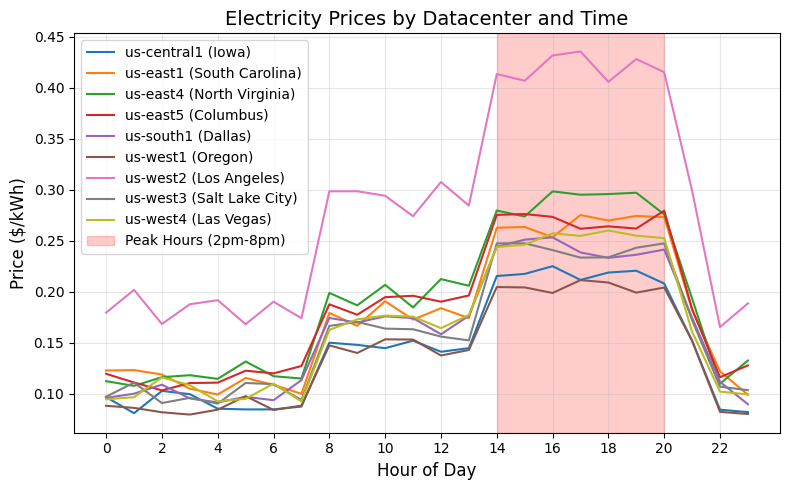

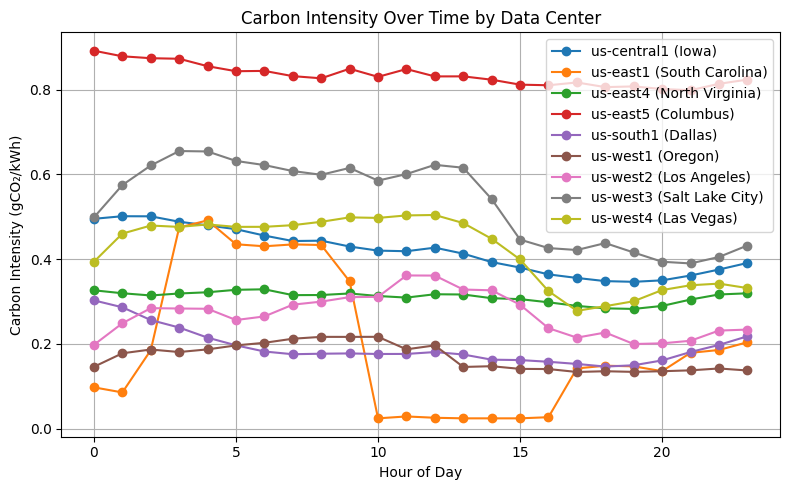

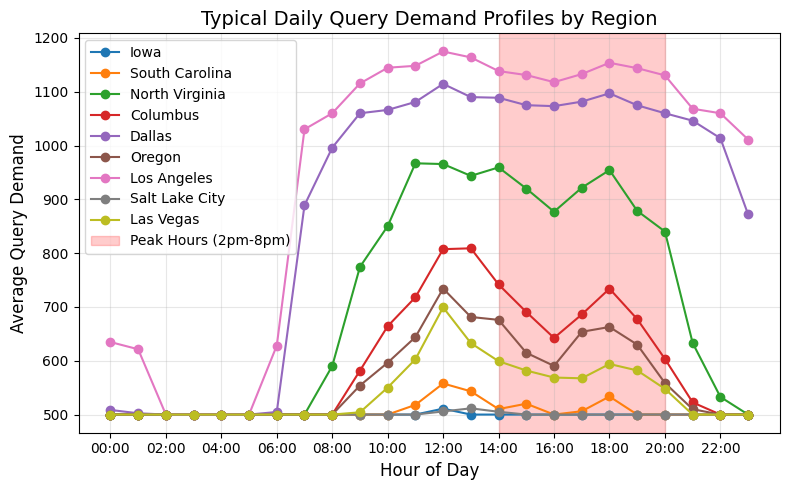

In [1]:
# Experiment
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import Green_LLM_model_official
import baseline_prob

class GreenLLMParameters:
    """
    Class for generating realistic parameters for the Green-LLM optimization model
    based on Google data center locations and real-world energy data.
    Includes query demand generation functionality.
    """
    
    def __init__(self, random_seed=42, min_queries=600, max_queries=1200):
        """
        Initialize the parameter generator with datacenter information and base prices.
        
        Parameters:
        -----------
        random_seed : int
            Random seed for reproducibility
        min_queries : int
            Minimum number of queries per time interval
        max_queries : int
            Maximum number of queries per time interval
        """
        # Set random seed for reproducibility
        np.random.seed(random_seed)
        
        # Define data center locations
        self.datacenter_info = {
            0: {"name": "us-central1", "location": "Iowa", "renewable": 0.95, "co2": 430},
            1: {"name": "us-east1", "location": "South Carolina", "renewable": 0.29, "co2": 560},
            2: {"name": "us-east4", "location": "Northern Virginia", "renewable": 0.52, "co2": 322},
            3: {"name": "us-east5", "location": "Columbus", "renewable": 0.52, "co2": 322},
            4: {"name": "us-south1", "location": "Dallas", "renewable": 0.79, "co2": 321},
            5: {"name": "us-west1", "location": "Oregon", "renewable": 0.84, "co2": 94},
            6: {"name": "us-west2", "location": "Los Angeles", "renewable": 0.55, "co2": 198},
            7: {"name": "us-west3", "location": "Salt Lake City", "renewable": 0.29, "co2": 588},
            8: {"name": "us-west4", "location": "Las Vegas", "renewable": 0.26, "co2": 373}
        }
        

        self.region_tax_factor = {
            "Los Angeles": 0.9,
            "Dallas": 0.2,
            "Las Vegas": 0.3,
            "Columbus": 0.6,
            "Oregon": 0.4,
            "South Carolina": 0.2,
            "Salt Lake City": 0.25,
            "North Virginia": 0.6,
            "Iowa": 0.5,
            }
        
        self.region_water_rate = {
            "Los Angeles": 0.8,
            "Dallas": 0.35,
            "Las Vegas": 0.45,
            "Columbus": 0.58,
            "Oregon": 0.43,
            "South Carolina": 0.52,
            "Salt Lake City": 0.84,
            "North Virginia": 0.74,
            "Iowa": 0.72,
            }
            
        # Define base electricity prices by location (cents per kWh)
        self.electricity_prices = {
            'Los Angeles': 22.5,      # California has higher rates
            'Dallas': 12.8,           # Texas has moderate rates
            'Las Vegas': 13.2,        # Nevada rates
            'Columbus': 14.5,         # Ohio rates
            'Oregon': 11.0,           # Oregon has lower rates due to hydropower
            'Salt Lake City': 12.5,   # Utah rates
            'South Carolina': 13.8,   # South Carolina rates
            'Iowa': 11.5,             # Iowa has lower rates 
            'North Virginia': 15.2    # Virginia rates
        }
        
        # Define the cities corresponding to each location for clarity
        self.location_to_city = {
            'Iowa': 'Des Moines',
            'South Carolina': 'Charlotte',
            'North Virginia': 'Washington',
            'Columbus': 'Columbus',
            'Dallas': 'Dallas',
            'Oregon': 'Portland',
            'Los Angeles': 'Los Angeles',
            'Salt Lake City': 'Salt Lake City',
            'Las Vegas': 'Las Vegas'
        }
        
        # Map datacenter IDs to locations for pricing
        self.datacenter_locations = {
            0: 'Iowa',            # us-central1
            1: 'South Carolina',  # us-east1
            2: 'North Virginia',  # us-east4
            3: 'Columbus',        # us-east5
            4: 'Dallas',          # us-south1
            5: 'Oregon',          # us-west1
            6: 'Los Angeles',     # us-west2
            7: 'Salt Lake City',  # us-west3
            8: 'Las Vegas'        # us-west4
        }
        
        # Round trip delay matrix (in seconds) for network latency between regions
        self.delay_matrix = np.array([
            # Des Moines row
            [0.000, 0.039, 0.034, 0.027, 0.026, 0.044, 0.049, 0.035, 0.042],
            # Charlotte row
            [0.039, 0.000, 0.021, 0.032, 0.041, 0.072, 0.068, 0.062, 0.059],
            # Washington row
            [0.034, 0.021, 0.000, 0.019, 0.046, 0.065, 0.061, 0.057, 0.055],
            # Columbus row
            [0.027, 0.032, 0.019, 0.000, 0.035, 0.052, 0.057, 0.045, 0.049],
            # Dallas row
            [0.026, 0.041, 0.046, 0.035, 0.000, 0.048, 0.037, 0.033, 0.031],
            # Portland row
            [0.044, 0.072, 0.065, 0.052, 0.048, 0.000, 0.023, 0.020, 0.027],
            # Los Angeles row
            [0.049, 0.068, 0.061, 0.057, 0.037, 0.023, 0.000, 0.018, 0.012],
            # Salt Lake City row
            [0.035, 0.062, 0.057, 0.045, 0.033, 0.020, 0.018, 0.000, 0.013],
            # Las Vegas row
            [0.042, 0.059, 0.055, 0.049, 0.031, 0.027, 0.012, 0.013, 0.000]
        ])

        # Define population by region (in millions)
        self.population_by_region = {
            0: 3.2,    # Iowa
            1: 5.1,    # South Carolina 
            2: 8.6,    # Northern Virginia (using Virginia population)
            3: 11.8,   # Ohio (Columbus)
            4: 29.0,   # Texas (Dallas)
            5: 4.2,    # Oregon
            6: 39.5,   # California (Los Angeles)
            7: 3.3,    # Utah (Salt Lake City)
            8: 3.1     # Nevada (Las Vegas)
        }
        



        # Define query popularity by type
        self.query_popularity = {
            0: 5,    # chat - very common
            1: 4,    # Text Summary - Common in content workflows
            2: 1.5,    # Math Solving - Popular among students, but niche
            3: 3,    # Code generation - Strong demand among devs, varies by platform
            4: 0.8     # Image generation - rare
        }
        self.datacenter_grid_mapping = {
            0: "Midcontinent ISO",                                    # Iowa
            1: "Southeastern Power Administration",                    # South Carolina
            2: "New York ISO",                                        # Northern Virginia
            3: "Louisville Gas and Electric Company and Kentucky Utilities", # Columbus
            4: "Electric Reliability Council of Texas",                # Dallas
            5: "Portland General Electric Company",                    # Oregon
            6: "Los Angeles Department of Water and Power",           # Los Angeles
            7: "Pacificorp East",                                     # Salt Lake City
            8: "Nevada Power Company"                                 # Las Vegas
        }
    
        # self.carbon_intensity_mapping_info = """
        # Carbon Intensity Data Mapping Notes:
        
        # 1. Midcontinent ISO (MISO) - Used for us-central1 (Iowa)
        #    MISO covers much of the Midwest including Iowa.
           
        # 2. Southeastern Power Administration - Used for us-east1 (South Carolina)
        #    SEPA covers the southeastern United States including South Carolina.
           
        # 3. New York ISO (NYISO) - Used for us-east4 (Northern Virginia)
        #    While Virginia is not part of NYISO, it's the closest grid region with available data.
           
        # 4. Louisville Gas and Electric Company (LG&E-KU) - Used for us-east5 (Columbus)
        #    This utility serves Kentucky and parts of adjacent states, close to Ohio.
           
        # 5. Electric Reliability Council of Texas (ERCOT) - Used for us-south1 (Dallas)
        #    ERCOT covers most of Texas including Dallas.
           
        # 6. Portland General Electric - Used for us-west1 (Oregon)
        #    This utility serves the Portland, Oregon area.
           
        # 7. Los Angeles Department of Water and Power - Used for us-west2 (Los Angeles)
        #    This utility serves the Los Angeles area.
           
        # 8. Pacificorp East - Used for us-west3 (Salt Lake City)
        #    Pacificorp serves areas including Utah (Salt Lake City).
           
        # 9. Nevada Power Company - Used for us-west4 (Las Vegas)
        #    This utility serves southern Nevada including Las Vegas.
        # """


        # Define spatial and time dimensions
        self.I = list(range(9))   # 9 user areas
        self.J = list(range(9))   # 9 data centers (from Google)
        self.K = list(range(5))   # 5 query types (chat; text summary; math solving; code generation; image generation)
        self.T = list(range(24))  # 24 time slots (hours in a day)
        self.R = list(range(3))   # 3 resource types (CPU, GPU, Memory)
        
        # Define query demand parameters
        # Base demand patterns by hour (24-hour cycle)
        self.hourly_patterns = np.array([
            0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9,  # 0-11
            1.0, 0.95, 0.9, 0.85, 0.8, 0.85, 0.9, 0.85, 0.75, 0.6, 0.5, 0.4  # 12-23
        ])
        
        # Create time zone offsets for different regions (simplified)
        self.time_offsets = np.zeros(len(self.I), dtype=int)
        self.time_offsets[0:5] = 0      # Eastern
        self.time_offsets[5:10] = 1     # Central 
        self.time_offsets[10:15] = 2    # Mountain
        self.time_offsets[15:20] = 3    # Pacific
        
        # Peak hours definition
        self.peak_hours = (14, 20)  # 2pm-8pm
        
        # Query limits
        self.min_queries = min_queries
        self.max_queries = max_queries
        
        # Create populations dictionary for demand calculation
        self.populations = {}
        for i, loc in self.datacenter_locations.items():
            self.populations[loc] = self.population_by_region[i]
        
        # Calculate population-based demand multipliers
        self._calculate_demand_multipliers()
        
        # Initialize parameters dictionary
        self.params = {}
    
    def _calculate_demand_multipliers(self):
        """Calculate demand multipliers based on population"""
        # Get total population
        total_population = sum(self.populations.values())
        
        # Calculate multipliers with normalization
        self.demand_multipliers = {}
        
        # Get min and max population
        min_pop = min(self.populations.values())
        max_pop = max(self.populations.values())
        
        for area, population in self.populations.items():
            # Normalize population to a range suitable for scaling
            # This ensures that even the smallest population areas get reasonable query volumes
            # normalize to [0, 1] range:  This shifts and rescales the normalized values to the range [0.5, 1.0] instead of [0, 1]
            # shift domain to [0, 1] and scale to [shift_lb, shift_ub]
            shift_lb = 0.3
            shift_ub = 1.0
            norm_factor = shift_lb + shift_ub * (population - min_pop) / (max_pop - min_pop)
            
            # Add some variation based on area characteristics
            area_lower = area.lower()
            
            # Apply some regional adjustments based on likely tech usage
            if 'los angeles' in area_lower or 'north virginia' in area_lower:
                # Higher tech usage in tech hubs
                regional_factor = 1.3
            elif 'oregon' in area_lower or 'dallas' in area_lower:
                # Regions with large data center presence
                regional_factor = 1.2
            elif 'las vegas' in area_lower:
                # Tourist areas with high transient population
                regional_factor = 1.2
            else:
                regional_factor = 0.8
            
            # Calculate final multiplier
            final_multiplier = norm_factor * regional_factor
            
            # Store multiplier
            self.demand_multipliers[area] = final_multiplier
    
    def _add_daily_variation(self, base_demand, day_of_week):
        """
        Add variation based on day of week
        
        Parameters:
        -----------
        base_demand : ndarray
            Base demand profile for a day
        day_of_week : int
            Day of week (0=Monday, 6=Sunday)
            
        Returns:
        --------
        ndarray
            Adjusted demand profile
        """
        # Weekday/weekend adjustment
        if day_of_week < 5:  # Weekday (Monday-Friday)
            if day_of_week < 3:  # Monday-Wednesday
                weekday_factor = np.ones(24)
                weekday_factor[9:17] = 1.2  # Higher during work hours
            else:  # Thursday-Friday
                weekday_factor = np.ones(24)
                weekday_factor[9:17] = 1.15  # Slightly higher during work hours
                weekday_factor[17:21] = 1.1  # Slightly higher in evening
        else:  # Weekend (Saturday-Sunday)
            weekend_factor = np.ones(24)
            weekend_factor[9:21] = 0.85  # Lower during daytime (outdoor activities)
            weekend_factor[21:24] = 1.2  # Higher late evening (entertainment)
            weekday_factor = weekend_factor
        
        adjusted_demand = base_demand * weekday_factor
        return adjusted_demand
    
    def _add_seasonal_variation(self, base_demand, month, area):
        """
        Add seasonal variation to demand
        
        Parameters:
        -----------
        base_demand : ndarray
            Base demand profile for a day
        month : int
            Month (1-12)
        area : str
            Area name
            
        Returns:
        --------
        ndarray
            Seasonally adjusted demand profile
        """
        # Tech usage tends to be higher in winter months and lower in summer
        seasonal_factors = {
            1: 1.2, 2: 1.15, 3: 1.1,    # Winter - early spring (higher indoor tech usage)
            4: 1.0, 5: 0.9, 6: 0.85,    # Late spring - early summer (more outdoor activities)
            7: 0.8, 8: 0.85, 9: 0.95,   # Summer - early fall (vacation season)
            10: 1.05, 11: 1.1, 12: 1.2  # Late fall - winter (holidays, indoor usage)
        }
        
        # Apply seasonal factor
        seasonal_factor = seasonal_factors[month]
        return base_demand * seasonal_factor
    
    def _add_random_variation(self, base_demand, std_dev=0.05):
        """
        Add random variation to demand
        
        Parameters:
        -----------
        base_demand : ndarray
            Base demand profile for a day
        std_dev : float
            Standard deviation for random noise
            
        Returns:
        --------
        ndarray
            Demand profile with random variation
        """
        # Generate random noise
        noise = np.random.normal(1.0, std_dev, size=base_demand.shape)
        
        # Ensure no negative values
        noise = np.maximum(noise, 0.8)
        
        # Apply noise
        return base_demand * noise
    
    def _emphasize_peak_hours(self, demand_profile):
        """
        Emphasize the peak hours (2pm-8pm) in the demand profile
        
        Parameters:
        -----------
        demand_profile : ndarray
            Base demand profile for a day
            
        Returns:
        --------
        ndarray
            Demand profile with emphasized peak hours
        """
        # Create a copy of the profile
        adjusted_profile = demand_profile.copy()
        
        # Create a peak-hour mask
        peak_mask = np.zeros(24, dtype=bool)
        start, end = self.peak_hours
        peak_mask[start:end+1] = True
        
        # Emphasize peak hours
        adjusted_profile[peak_mask] *= 1.3
        
        # Normalize to maintain the same daily total
        original_sum = demand_profile.sum()
        adjusted_profile = adjusted_profile * (original_sum / adjusted_profile.sum())
        
        return adjusted_profile
    
    def _scale_to_query_range(self, demand_values):
        """
        Scale demand values to integer query counts within specified range
        
        Parameters:
        -----------
        demand_values : ndarray
            Raw demand values
            
        Returns:
        --------
        ndarray
            Integer query counts
        """
        # Scale to the specified range
        min_val = np.min(demand_values)
        max_val = np.max(demand_values)
        
        # Avoid division by zero
        if max_val == min_val:
            scaled = np.full_like(demand_values, (self.min_queries + self.max_queries) // 2)
        else:
            scaled = self.min_queries + (demand_values - min_val) * (self.max_queries - self.min_queries) / (max_val - min_val)
        
        # Convert to integers
        return np.round(scaled).astype(int)
    
    def generate_all_parameters(self):
        """
        Generate all parameters for the Green-LLM optimization model.
        
        Returns:
        --------
        dict
            Dictionary of all parameters
        """
        # Add sets
        self.params['I'] = self.I
        self.params['J'] = self.J
        self.params['K'] = self.K
        self.params['T'] = self.T
        self.params['R'] = self.R
        
        # Generate query demand using the integrated method
        self.generate_query_demand_for_params(self.params, self.I, self.K, self.T)
        
        # Generate delay matrix
        self.generate_delay_matrix()

        # Generate token counts
        self.generate_token_counts()
        
        # Generate electricity prices
        self.generate_electricity_prices()
        # generate delay penalty 
        self.generate_delay_penalty_parameters()
        
        # Generate energy-related parameters
        self.generate_energy_parameters()
        
        # Generate resource-related parameters
        self.generate_resource_parameters()
        
        # Generate network-related parameters
        self.generate_network_parameters()
        
        # Generate water-related parameters
        self.generate_water_parameters()

        
        return self.params

    def generate_query_demand_for_params(self, params, I, K, T):
        """
        Generate query demand data and store it in the params dictionary using key 'lmbda'
    
        Parameters:
        -----------
        params : dict
            Parameters dictionary where demand data will be stored
        I : list
            List of user region indices
        K : list
            List of query types
        T : list
            List of time slots
        
        Returns:
        --------
        dict
            Updated params dictionary with 'lmbda' key
        """
        # Convert area names to indices for mapping
        area_names = list(self.populations.keys())
    
        # Initialize demand dictionary
        lmbda = {}
    
        # Generate demand for each combination of i, k, t
        for i in I:
            area = self.datacenter_locations[i]  # Map index to area name
            area_multiplier = self.demand_multipliers[area]
     
            for k in K:
                # Apply query type factor (higher for common types, lower for rare ones)
                if k == 1:  # Text Summary
                    type_factor = 1.8
                elif k == 0:  # Chat - very common
                    type_factor = 2
                elif k == 4:  # Image generation - rare
                    type_factor = 0.5
                elif k == 2:  # Math-solving
                    type_factor = 1.5
                else:  # Code generation - common but not as much as chat
                    type_factor = 1.2
       
                for t in T:
                    # Get base hourly pattern
                    base_hourly_value = self.hourly_patterns[t % 24]
                
                    # Add daily variation
                    day = t // 24 if len(T) > 24 else 0
                    day_of_week = day % 7
                    daily_adjusted = self._add_daily_variation(np.array([base_hourly_value]), day_of_week)[0]
                
                    # Add seasonal variation (using March as the default month)
                    month = 3
                    seasonally_adjusted = self._add_seasonal_variation(np.array([daily_adjusted]), month, area)[0]
                    
                    # Add random variation
                    final_value = self._add_random_variation(np.array([seasonally_adjusted]))[0]
                    
                    # Scale by area multiplier and query type factor
                    demand_value = final_value * area_multiplier * type_factor
                    
                    # Generate an integer value between min_queries and max_queries
                    min_val = self.min_queries
                    max_val = self.max_queries
                    
                    # Scale to the desired range
                    scaled_value = min_val + (demand_value - 0.5) * (max_val - min_val) / 0.5
                    
                    # Ensure values are within bounds and convert to integer
                    lmbda[(i, k, t)] = max(min_val, min(max_val, int(round(scaled_value))))
        
        # Store in params dictionary
        params['lambda'] = lmbda
        
        # Create a DataFrame for demand analysis (optional)
        demand_data = []
        for i in I:
            for k in K:
                for t in T:
                    demand_data.append({
                        'region': i, 
                        'region_name': self.datacenter_locations[i],
                        'query_type': k,
                        'hour': t,
                        'demand': lmbda[(i, k, t)],
                        'population': self.population_by_region[i]
                    })
        
        self.demand_data = pd.DataFrame(demand_data)
        
        return params
    
    def get_query_demand_data(self):
        """
        Return a DataFrame of query demand data for analysis
        
        Returns:
        --------
        DataFrame
            DataFrame containing query demand by region, query type, and time
        """
        if not hasattr(self, 'demand_data'):
            demand_data = []
            for i in self.I:
                for k in self.K:
                    for t in self.T:
                        demand_data.append({
                            'region': i, 
                            'region_name': self.datacenter_locations[i],
                            'query_type': k,
                            'hour': t,
                            'demand': self.params['lmbda'][(i, k, t)]
                        })
            self.demand_data = pd.DataFrame(demand_data)
        
        return self.demand_data    
    def generate_delay_matrix(self):
        """
        Generate a delay matrix based on the provided datacenter locations.
        """
        # Create a list of cities in the order of the indices
        cities = [self.location_to_city[self.datacenter_locations[j]] for j in self.J]
        
        # Replace diagonal zeros with small random values between 0.001 and 0.009
        # This represents the minimal latency within the same region
        np.random.seed(42)  # For reproducibility
        np.fill_diagonal(self.delay_matrix, np.random.uniform(0.001, 0.009, len(self.J)))
        

        # Create the dictionary mapping (i,j) to delay values
        d = {}
        for i in self.I:
            for j in self.J:
                d[(i, j)] = self.delay_matrix[i][j]
                
        self.params['d'] = d
        return d
    
    def generate_token_counts(self):
        """Generate token count parameters"""
        # Token counts for different query types (input)
        h = {
            0: 80,    # Chat
            1: 500,   # Text-Summary
            2: 50,   # Math-Solving
            3: 40,  # Code-generation
            4: 30    # Image-geneation
        }
        self.params['h'] = h
        
        # Output token counts
        f = {
            0: 100,    # Chat
            1: 300,    # Text-Summary
            2: 100,   # Math-Solving
            3: 500,    # Code-generation
            4: 10     # Image-geneation
        }
        self.params['f'] = f

    def generate_electricity_prices(self):
        """Generate electricity price parameters with time-of-use pricing"""
        # Initialize empty electricity price dictionary
        c = {}
        
        # Generate time-of-use prices for each datacenter and time period
        for j in self.J:
            # Get location for this datacenter
            location = self.datacenter_locations.get(j)
            
            # Get the base price (default to average if location not found)
            if location in self.electricity_prices:
                base_price = self.electricity_prices[location] / 100.0  # Convert cents to dollars
            else:
                base_price = 0.15  # Default average price if location not found
            
            for t in self.T:
                # Apply time-of-day pricing with more realistic patterns
                hour = t % 24  # Convert time period to hour of day
                
                if 14 <= hour <= 20:  # Peak hours (2pm-8pm)
                    # Higher premium during peak demand
                    factor = 1.8 + 0.2 * np.random.random()  # 50-80% premium
                elif 8 <= hour < 14 or 20 < hour < 22:  # Shoulder periods
                    # Moderate premium during shoulder hours
                    factor = 1.2 + 0.2 * np.random.random()  # 20-40% premium
                else:  # Off-peak (night/early morning)
                    # Discount during off-peak
                    factor = 0.7 + 0.2 * np.random.random()  # 30-50% discount
                
                # Add some day-of-week variation if T includes multiple days
                day = t // 24 if len(self.T) > 24 else 0
                
                # Weekend discount (if applicable)
                if day % 7 >= 5:  # Saturday or Sunday
                    factor *= 0.9  # 10% discount on weekends
                
                # Final price calculation
                c[(j, t)] = base_price * factor
        
        # Store in parameters dictionary
        self.params['c'] = c
    
    def generate_energy_parameters(self):
        """Generate energy-related parameters"""
        # Tau_in and tau_out is with unit Joules/token
        # Energy consumption coefficients
        tau_in_J = {k: 20 + 20 * np.random.random() for k in self.K}  # Input token energy in Joules/token
        tau_out_J = {k: 50 + 50 * np.random.random() for k in self.K}  # Output token energy in Joules/token
        # convert to Kwh/token
        tau_in = {k: tau_in_J[k] / 3600000 for k in self.K}
        tau_out = {k: tau_out_J[k] / 3600000 for k in self.K} 
        self.params['tau_in'] = tau_in
        self.params['tau_out'] = tau_out
        
        # Carbon intensity (kg CO2/kWh) - from Google data (Time-invariant (monthly average data))
        # theta = {(j,t): self.datacenter_info[j]['co2'] / 1000.0 for j in self.J for t in self.T}  # Convert g to kg
        # self.params['theta'] = theta


        # Carbon tax ($/tons CO2): If it was kg, we need to devided by 1000


        
        carbon_tax_base = 50.0  # $/ton = 0.05 $/kg
        # delta = {(j): carbon_tax_base * (0.001 + 0.01 * np.random.random())/1000 for j in self.J}
       
        delta = {j: carbon_tax_base * self.region_tax_factor[self.datacenter_locations[j]]/1000 for j in self.J}

        self.params['delta'] = delta



        # Load the carbon intensity data file (carbon intensity is convert to kg)
        # file_path = "C:\Users\jiami\ASU Dropbox\Jiaming Cheng\Network_letter\carbon_data\consolidated_carbon_intensity_march24_filled.csv"
        carbon_df = pd.read_csv("consolidated_carbon_intensity_march24_filled.csv")
        
        # energy_demand_j in kWh
        # carbon_intensity_j in gCO2/kWh
        # delta_j in $/kg       
        theta = {}
        for j, grid_name in self.datacenter_grid_mapping.items():
            # Find the matching column by looking for the grid name in the column headers
            matching_col = None
            for col in carbon_df.columns:
                if grid_name in col:
                    matching_col = col
                    break
                    
            if matching_col is None:
                print(f"Warning: No matching column found for {grid_name}")
                continue
                
            # Extract carbon intensity values
            carbon_intensity_series = carbon_df[matching_col] / 1000.0  # convert to kg
            for t in range(len(carbon_intensity_series)):
                theta[(j, t)] = round(carbon_intensity_series[t], 6)
                
        self.params['theta'] = theta

        # Renewable energy availability (kW)
        P_w = {}
        for j in self.J:
            renewable_percentage = self.datacenter_info[j]['renewable']
            base_capacity = np.random.randint(50, 100)  # Base datacenter capacity
            
            for t in self.T:
                # Solar generation curve (for daytime hours)
                solar_factor = 0
                if 6 <= t < 18:  # Daylight hours
                    # Peak at noon, lower at dawn/dusk
                    hour_factor = 1.0 - abs(t - 12) / 6.0
                    solar_factor = hour_factor * renewable_percentage
                    
                # Wind generation (less predictable)
                wind_factor = 0.5 * renewable_percentage * np.random.random()
                
                # Total renewable factor
                total_factor = solar_factor + wind_factor
                
                # Final renewable capacity for this data center and time
                P_w[(j, t)] = base_capacity * total_factor
        self.params['P_w'] = P_w
        
        # Maximum power from grid (kW)
        P_max = {(j, t): np.random.randint(4000, 5000) for j in self.J for t in self.T}
        self.params['P_max'] = P_max
        
        # Power Usage Effectiveness
        # Modern data centers range from 1.1 (very efficient) to 1.5 (average)
        PUE = {j: 1.0 + 0.4 * np.random.random() for j in self.J}
        self.params['PUE'] = PUE
    
    def generate_resource_parameters(self):
        """Generate resource-related parameters"""
        # Resource capacity (units)
        C = {(r, j): np.random.randint(40000, 50000) for r in self.R for j in self.J}
        self.params['C'] = C
        
        # Resource requirements per query type
        alpha = {}
        for k in self.K:
            for r in self.R:
                # Different query types need different resources
                if r == 0:  # CPU
                    alpha[(k, r)] = 0.001 + 0.0005 * np.random.random()
                elif r == 1:  # GPU
                    # Fine-tuning and large models need more GPU
                    if k in [2, 3]:
                        alpha[(k, r)] = 0.0015 + 0.0005 * np.random.random()
                    else:
                        alpha[(k, r)] = 0.002 + 0.0005 * np.random.random()
                else:  # Memory
                    alpha[(k, r)] = 0.01 + 0.005 * np.random.random()
        self.params['alpha'] = alpha
        # Resource index: 0 = CPU, 1 = Memory, 2 = GPU



        # Previous model placement
        z_prev = {}
        for j in self.J:
            for k in self.K:
                        z_prev[(j, k)] = np.random.randint(0, 2)  # Randomly placed or not
        self.params['z_prev'] = z_prev

        
        # Model download cost (units)
        f_download = {(j, k): 0 + 0 * np.random.random() for j in self.J for k in self.K}
        self.params['f_download'] = f_download
    
    
    # the delay penalty parameter is defined with proportion to the number of queries
    def generate_delay_penalty_parameters(self):
        """Generate delay penalty parameters based on total number of queries"""
        # Calculate total number of queries across all regions, query types, and time periods
        total_queries = sum(self.params['lambda'][(i, k, t)] for i in self.I for k in self.K for t in self.T)
        
        # Base penalty that scales with total queries
        base_rho = 10000
        
        # Delay penalty parameters - higher total queries = higher penalties
        rho = {}
        for k in self.K:
            # Different query types have different penalty sensitivities
            type_multiplier = {
                0: 10,    # Chat
                1: 12,    # Text Summary
                2: 6,    # Math Solving
                3: 4,    # Code Generation
                4: 1.5     # Image Generation
            }.get(k, 1.0)
            
            rho[k] = base_rho / total_queries * type_multiplier
        self.params['rho'] = rho
        


# For tokensize parameters: 
# Each token, when serialized as input for inference (e.g., sent as plain text or JSON), typically averages between 2–5 characters per token.
# UTF-8 encoded characters typically require about 1 byte per ASCII character and up to 4 bytes per non-ASCII (Unicode) character.
# For instance
# 1 Token = 4 bytes (average) = 0.000004 GB = 0.000004 * 1024 KB = 0.004 KB ~ Tipycally 2-5 bytes per token for english text
# English typical text (GPT 4) Avertage char/token = 4 characters/token ~ 4 bytes/token ~ 0.000004 GB/token ~ 0.004 KB/token
# Code generation (GPT 4) Avertage char/token = 5-8 characters/token ~ 5-8 bytes/token ~ 0.000005 GB/token ~ 0.005 KB/token
# 1 byte = 1/1024 KB = 0.000001 GB = 0.0039 KB/token
# in bits per token: 1 byte = 8 bits, so 1 token = 8 bits * 4 bytes = 32 bits/token
 
    
    def generate_network_parameters(self):
        """Generate network-related parameters"""
        # Token size (KB)
        beta = {(i, k, t): 0.003 + 0.002 * np.random.random() for i in self.I for k in self.K for t in self.T}
        self.params['beta'] = beta
        
        # Network bandwidth (Mbps)
        B = {}
        for i in self.I:
            for j in self.J:
                # Distance factor: closer regions have higher bandwidth
                # Network bandwidth (Mbps)
                region_i = i // 5  # 0=East, 1=Central, 2=Mountain, 3=West
                region_j = 0
                if j in [0]:
                    region_j = 1  # Central
                elif j in [1, 2, 3]:
                    region_j = 0  # East
                elif j in [4]:
                    region_j = 1  # South (treat as Central)
                else:
                    region_j = 3  # West
                    
                distance = abs(region_i - region_j)
                base_bw = 3000 # Realistic base bandwidth in Mbps (3 Gbps)
                
                # Further distances have more bandwidth variability and lower average
                bandwidth = base_bw * (1.0 - 0.1 * distance) * (0.7 + 0.6 * np.random.random())
                B[(i, j)] = max(100, bandwidth)  # Minimum 100 Mbps
        self.params['B'] = B
        
        # Processing delay (s/token) ~ GPU-based inference processing delay per token (0.5 to 2.0 seconds)

        # Estimated processing delay per token (sec/token) for each query type
        base_v = {
            0: 0.000001,   # Chat: very fast
            1: 0.0000015,   # Text Summary: slightly slower
            2: 0.00002,   # Math Solving: complex reasoning
            3: 0.00002,   # Code Generation: more compute-heavy
            4: 0.00005    # Image Generation: very GPU-intensive
        }
        v = {}
        for j in self.J:
            for k in self.K:
                heterogeneity = np.random.uniform(0.9, 1.1)  # ±10%
                v[(j, k)] = round(base_v[k] * heterogeneity, 6)
        self.params['v'] = v
        
        
        # Define base delay thresholds (in seconds)
        Delta = {}
        # Define realistic base delays for each workload type
        realistic_base_delays = {
            0: 5,    # Chat
            1: 10,    # Text-Summary
            2: 15.0,    # Math-Solving
            3: 20.0,    # Code-generation
            4: 30.0    # Image-generation
        }

        # Generate Delta directly
        for i in self.I:  # areas
            for k in self.K:  # workload types
                variability = np.random.uniform(1.0,1.5)
                Delta[(i, k)] = round(realistic_base_delays[k] * variability, 2)

        # Wrap in params
        self.params['Delta'] = Delta
        
        

    
    def generate_water_parameters(self):
        """Generate water-related parameters"""
        # Water Usage Effectiveness
        WUE = {(j, t): 0.5 + 0.5 * np.random.random() for j in self.J for t in self.T}
        self.params['WUE'] = WUE
        
        # Energy-Water Intensity Factor
        EWIF = {(j, t): 0.1 + 0.5 * np.random.random() for j in self.J for t in self.T}
        self.params['EWIF'] = EWIF
        
        # Maximum water consumption
        Z = np.random.uniform(5000, 6000)
        self.params['Z'] = Z



        s_woc = {j: self.region_water_rate[self.datacenter_locations[j]] for j in self.J}
        self.params['s_woc'] = s_woc

        
    def get_electricity_price_data(self):
        """
        Return a DataFrame of electricity prices for analysis
        
        Returns:
        --------
        DataFrame
            DataFrame containing electricity prices by datacenter and time
        """
        price_data = []
        
        for j in self.J:
            location = self.datacenter_locations.get(j)
            for t in self.T:
                price_data.append({
                    'datacenter_id': j,
                    'datacenter_name': self.datacenter_info[j]['name'],
                    'location': location,
                    'hour': t,
                    'price': self.params['c'][(j, t)]
                })
        
        return pd.DataFrame(price_data)
        

    
    def plot_electricity_prices(self, figsize=(8, 5)):
        """
        Plot electricity prices for all datacenters
    
        Parameters:
        -----------
        figsize : tuple
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure
            The created figure
        """
        # Get price data
        price_df = self.get_electricity_price_data()
    
        # Create plot
        fig, ax = plt.subplots(figsize=figsize)
    
        # Plot price for each datacenter
        for j in self.J:
            dc_prices = price_df[price_df['datacenter_id'] == j]
            hours = dc_prices['hour'].values  # Convert to numpy array
            prices = dc_prices['price'].values  # Convert to numpy array
            ax.plot(hours, prices, 
                   label=f"{self.datacenter_info[j]['name']} ({self.datacenter_locations[j]})")
    
        # Add peak hour shading
        ax.axvspan(14, 20, alpha=0.2, color='red', label='Peak Hours (2pm-8pm)')
    
        # Add labels and legend
        ax.set_title('Electricity Prices by Datacenter and Time', fontsize=14)
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Price ($/kWh)', fontsize=12)
        ax.set_xticks(range(0, 24, 2))
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
    
        plt.tight_layout()
        return fig
    
    def plot_carbon_intensity(self, figsize=(8, 5)):

        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)

        for j in self.J:
            intensity = [self.params['theta'][j, t] for t in self.T]
            ax.plot(self.T, intensity, label=f"{self.datacenter_info[j]['name']} ({self.datacenter_locations[j]})", marker='o')

        ax.set_xlabel("Hour of Day")
        ax.set_ylabel("Carbon Intensity (gCO₂/kWh)")
        ax.set_title("Carbon Intensity Over Time by Data Center")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig


    def plot_daily_query_profiles(self, figsize=(8, 5)):
        """
        Plot typical daily query demand profiles for all regions
        
        Parameters:
        -----------
        figsize : tuple
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure
            The created figure
        """
        # Get daily profiles
        profiles = {}
        
        # Extract daily profiles from the lambda data
        for i in self.I:
            region_profile = np.zeros(24)
            for t in range(24):  # 24 hours in a day
                for k in self.K:
                    region_profile[t] += self.params['lambda'][(i, k, t)]
                    
            # Average across query types
            region_profile = region_profile / len(self.K)
            profiles[self.datacenter_locations[i]] = region_profile
        
        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Hours of the day
        hours = np.arange(24)
        
        # Plot profile for each area
        for area, profile in profiles.items():
            ax.plot(hours, profile, label=area, marker='o')
        
        # Add peak hour shading
        ax.axvspan(14, 20, alpha=0.2, color='red', label='Peak Hours (2pm-8pm)')
        
        # Add labels and legend
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Average Query Demand', fontsize=12)
        ax.set_title('Typical Daily Query Demand Profiles by Region', fontsize=14)
        ax.set_xticks(np.arange(0, 24, 2))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        plt.tight_layout()
        return fig
    
    def plot_query_demand_by_type(self, region_idx=0, figsize=(8, 5)):
        """
        Plot query demand by query type for a specific region
        
        Parameters:
        -----------
        region_idx : int
            Index of the region to plot
        figsize : tuple
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure
            The created figure
        """
        # Extract demand by query type
        query_profiles = {}
        
        for k in self.K:
            profile = np.zeros(24)
            for t in range(24):  # 24 hours in a day
                profile[t] = self.params['lmbda'][(region_idx, k, t)]
   
            # Map query type to name
            query_names = {
                0: "Chat",
                1: "Text-Summary",
                2: "Math",
                3: "Code-generation",
                4: "Image-generation"
            }
            query_profiles[query_names[k]] = profile
        
        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Hours of the day
        hours = np.arange(24)
        
        # Plot profile for each query type
        for query_type, profile in query_profiles.items():
            ax.plot(hours, profile, label=query_type, marker='o')
        
        # Add peak hour shading
        ax.axvspan(14, 20, alpha=0.2, color='red', label='Peak Hours (2pm-8pm)')
        
        # Add labels and legend
        region_name = self.datacenter_locations[region_idx]
        ax.set_xlabel('Hour of Day', fontsize=12)
        ax.set_ylabel('Query Demand', fontsize=12)
        ax.set_title(f'Query Demand by Type for {region_name}', fontsize=14)
        ax.set_xticks(np.arange(0, 24, 2))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        plt.tight_layout()
        return fig
    
    def export_parameters_to_csv(self, output_dir='.'):
        """
        Export key parameters to CSV files for analysis
        
        Parameters:
        -----------
        output_dir : str
            Directory to save output files
            
        Returns:
        --------
        dict
            Dictionary of output file paths
        """
        import os
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate timestamp for filenames
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Export electricity prices
        price_df = self.get_electricity_price_data()
        price_path = os.path.join(output_dir, f'electricity_prices_{timestamp}.csv')
        price_df.to_csv(price_path, index=False)
        
        # Export query demand
        demand_df = self.get_query_demand_data()
        demand_path = os.path.join(output_dir, f'query_demand_{timestamp}.csv')
        demand_df.to_csv(demand_path, index=False)
        
        # Export delay matrix
        delay_data = []
        for i in self.I:
            for j in self.J:
                delay_data.append({
                    'source_region': i,
                    'source_location': self.datacenter_locations[i],
                    'destination_datacenter': j,
                    'destination_location': self.datacenter_locations[j],
                    'delay': self.params['d'][(i, j)]
                })
        delay_df = pd.DataFrame(delay_data)
        delay_path = os.path.join(output_dir, f'delay_matrix_{timestamp}.csv')
        delay_df.to_csv(delay_path, index=False)
        
        return {
            'electricity_prices': price_path,
            'query_demand': demand_path,
            'delay_matrix': delay_path
        }

# Example usage
if __name__ == "__main__":
    # Create parameter generator
    generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
    
    # Generate all parameters
    params = generator.generate_all_parameters()
    # print carbon intensity
    print(f"Carbon intensity: {params['theta']}")
    print(f"Delay Threshold: {params['Delta']}") 
    # Print some sample electricity prices
    print("\nSample electricity prices ($/kWh):")
    sample_j = 0  # First datacenter (Iowa)
    for hour in range(0, 24, 4):  # Sample every 4 hours
        print(f"Datacenter {sample_j} ({generator.datacenter_info[sample_j]['name']}) at hour {hour}: ${params['c'][(sample_j, hour)]:.4f}")
    
    # Print some sample query demands
    print("\nSample query demands:")
    sample_i = 0  # First region (Iowa)
    sample_k = 1  # Chat queries
    for hour in range(0, 24, 4):  # Sample every 4 hours
        print(f"Region {sample_i} ({generator.datacenter_locations[sample_i]}) at hour {hour}, query type {sample_k}: {params['lambda'][(sample_i, sample_k, hour)]} queries")
    
    # Plot electricity prices
    try:
        price_fig = generator.plot_electricity_prices()
        price_fig.savefig('electricity_prices.png')
        print("\nElectricity price plot saved as 'electricity_prices.png'")
        carbon_fig = generator.plot_carbon_intensity()
        carbon_fig.savefig('carbon_intensity.png')
        print("\nCarbon intensity plot saved as 'carbon_intensity.png'")
    except Exception as e:
        print(f"Could not create price plot: {str(e)}")
    
    # Plot query demand profiles
    try:
        demand_fig = generator.plot_daily_query_profiles()
        demand_fig.savefig('query_demand.png')
        print("Query demand plot saved as 'query_demand.png'")
    except Exception as e:
        print(f"Could not create demand plot: {str(e)}")
    
    # Export parameters to CSV
    try:
        output_files = generator.export_parameters_to_csv()
        print("\nParameters exported to CSV files:")
        for file_type, file_path in output_files.items():
            print(f"- {file_type}: {file_path}")
    except Exception as e:
        print(f"Could not export parameters: {str(e)}")

In [2]:
import Green_model 
import baseline_prob
import epi_constraint
import lexicographic_model

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
params = generator.generate_all_parameters()
m0_model, m0_sol = Green_model.green_llm_optimization(params)
m1_model, m1_sol = baseline_prob.m1_model(params)
m2_model, m2_sol = baseline_prob.m2_model(params)
m3_model, m3_sol = baseline_prob.m3_model(params)
print(params['rho'])
print("---------------- cost summary ----------------")
print(m0_sol['m0_cost'])
print(m1_sol['m1_cost'])
print(m2_sol['m2_cost'])
print(m3_sol['m3_cost'])    
print("---------------- Energy summary ----------------")
print(sum(m0_sol['C_energy_with_time']))
print(m1_sol['m1_C_energy'])
print(m2_sol['m2_C_energy'])
print(m3_sol['m3_C_energy'])
print("---------------- Carbon summary ----------------")
print(sum(m0_sol['C_carbon_with_time']))
print(m1_sol['m1_C_carbon'])
print(m2_sol['m2_C_carbon'])
print(m3_sol['m3_C_carbon'])
print("---------------- Delay summary ----------------")
print(sum(m0_sol['C_delay_with_time']))
print(m1_sol['m1_C_delay'])
print(m2_sol['m2_C_delay'])
print(m3_sol['m3_C_delay'])

print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['energy', 'delay', 'carbon'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


pareto_solutions, pareto_df = epi_constraint.generate_pareto_frontier(params, n_points=5, primary_objective='delay')
analysis = epi_constraint.analyze_pareto_solutions(pareto_solutions, pareto_df)
        
print(f"\n=== Pareto Frontier Analysis ===")
print(f"\n=== epi_constraint solution ===")
# print(f"Number of Pareto-optimal solutions: {analysis['num_solutions']}")
print(f"Energy cost range: [{analysis['energy_stats']['min']:.2f}, {analysis['energy_stats']['max']:.2f}]")
print(f"Carbon cost range: [{analysis['carbon_stats']['min']:.2f}, {analysis['carbon_stats']['max']:.2f}]")
print(f"Delay cost range: [{analysis['delay_stats']['min']:.2f}, {analysis['delay_stats']['max']:.2f}]")
# print the C_energy_cost, C_carbon_cost, C_delay_cost, C_total_cost
print(pareto_solutions[0]['C_energy_cost'])
print(pareto_solutions[0]['C_carbon_cost'])
print(pareto_solutions[0]['C_delay_cost'])
print(pareto_solutions[0]['C_total_cost'])

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-18
{0: 0.14445689983936394, 1: 0.17334827980723672, 2: 0.08667413990361836, 3: 0.057782759935745574, 4: 0.02166853497590459}
---------------- cost summary ----------------
392.0825457532911
415.15312669383144
425.9958766627137
392.978808180079
---------------- Energy summary ----------------
197.6267313046913
193.93567643245248
207.154496479408
201.07908455131064
---------------- Carbon summary ----------------
5.459978235937458
8.529658655188655
2.0896638903797404
3.617313254562742
---------------- Delay summary ----------------
188.9958362126623
212.6877916061903
216.751716292926
188.2824103742056

=== LEXICOGRAPHIC SOLUTION ===
Priority order: energy > delay > carbon
--------------------------------------------------

Phase 1: Optimizing ENERGY
   Optimal energy: 193.94
   Current costs - Energy: 193.94, Carbon: 8.53, Delay: 212.69

Phase 2: Optimizing DELAY
   Adding constraint: energy ≤ 194.13


In [3]:
print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['energy', 'delay', 'carbon'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


=== LEXICOGRAPHIC SOLUTION ===
Priority order: energy > delay > carbon
--------------------------------------------------

Phase 1: Optimizing ENERGY
   Optimal energy: 193.94
   Current costs - Energy: 193.94, Carbon: 8.53, Delay: 212.69

Phase 2: Optimizing DELAY
   Adding constraint: energy ≤ 194.13
   Optimal delay: 192.00
   Current costs - Energy: 194.13, Carbon: 8.47, Delay: 192.00

Phase 3: Optimizing CARBON
   Adding constraint: energy ≤ 194.13
   Adding constraint: delay ≤ 192.19
   Optimal carbon: 8.14
   Current costs - Energy: 194.13, Carbon: 8.14, Delay: 192.19
Total Cost: 394.46
Energy: 194.13
Carbon: 8.14
Delay: 192.19


In [4]:
print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['energy', 'carbon', 'delay'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


=== LEXICOGRAPHIC SOLUTION ===
Priority order: energy > carbon > delay
--------------------------------------------------

Phase 1: Optimizing ENERGY
   Optimal energy: 193.94
   Current costs - Energy: 193.94, Carbon: 8.53, Delay: 212.69

Phase 2: Optimizing CARBON
   Adding constraint: energy ≤ 194.13
   Optimal carbon: 7.84
   Current costs - Energy: 194.13, Carbon: 7.84, Delay: 214.70

Phase 3: Optimizing DELAY
   Adding constraint: energy ≤ 194.13
   Adding constraint: carbon ≤ 7.85
   Optimal delay: 193.68
   Current costs - Energy: 194.13, Carbon: 7.85, Delay: 193.68
Total Cost: 395.66
Energy: 194.13
Carbon: 7.85
Delay: 193.68


In [5]:
print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['delay', 'energy', 'carbon'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


=== LEXICOGRAPHIC SOLUTION ===
Priority order: delay > energy > carbon
--------------------------------------------------

Phase 1: Optimizing DELAY
   Optimal delay: 179.82
   Current costs - Energy: 173164.76, Carbon: 8376.22, Delay: 179.82

Phase 2: Optimizing ENERGY
   Adding constraint: delay ≤ 180.00
   Optimal energy: 425.30
   Current costs - Energy: 425.30, Carbon: 23.60, Delay: 180.00

Phase 3: Optimizing CARBON
   Adding constraint: delay ≤ 180.00
   Adding constraint: energy ≤ 425.72
   Optimal carbon: 22.51
   Current costs - Energy: 425.72, Carbon: 22.51, Delay: 180.00
Total Cost: 628.24
Energy: 425.72
Carbon: 22.51
Delay: 180.00


In [6]:
print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['delay', 'carbon', 'energy'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


=== LEXICOGRAPHIC SOLUTION ===
Priority order: delay > carbon > energy
--------------------------------------------------

Phase 1: Optimizing DELAY
   Optimal delay: 179.82
   Current costs - Energy: 173164.76, Carbon: 8376.22, Delay: 179.82

Phase 2: Optimizing CARBON
   Adding constraint: delay ≤ 180.00
   Optimal carbon: 18.60
   Current costs - Energy: 447.56, Carbon: 18.60, Delay: 180.00

Phase 3: Optimizing ENERGY
   Adding constraint: delay ≤ 180.00
   Adding constraint: carbon ≤ 18.62
   Optimal energy: 443.58
   Current costs - Energy: 443.58, Carbon: 18.62, Delay: 180.00
Total Cost: 642.20
Energy: 443.58
Carbon: 18.62
Delay: 180.00


In [7]:
print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['carbon', 'delay', 'energy'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


=== LEXICOGRAPHIC SOLUTION ===
Priority order: carbon > delay > energy
--------------------------------------------------

Phase 1: Optimizing CARBON
   Optimal carbon: 2.09
   Current costs - Energy: 207.15, Carbon: 2.09, Delay: 216.75

Phase 2: Optimizing DELAY
   Adding constraint: carbon ≤ 2.09
   Optimal delay: 195.49
   Current costs - Energy: 207.13, Carbon: 2.09, Delay: 195.49

Phase 3: Optimizing ENERGY
   Adding constraint: carbon ≤ 2.09
   Adding constraint: delay ≤ 195.69
   Optimal energy: 207.11
   Current costs - Energy: 207.11, Carbon: 2.09, Delay: 195.69
Total Cost: 404.89
Energy: 207.11
Carbon: 2.09
Delay: 195.69


In [8]:
print(f"\n=== LEXICOGRAPHIC SOLUTION ===")
# print solution from lexicographic method
# Call the function and capture its return values
model, lexi_sol, phase_results = lexicographic_model.lexicographic_green_llm(params, priority_order=['carbon', 'energy', 'delay'])
# Now you can print the solution
if lexi_sol:  # Check if solution was found
    print(f"Total Cost: {lexi_sol['total_cost']:.2f}")
    print(f"Energy: {lexi_sol['C_energy_cost']:.2f}")
    print(f"Carbon: {lexi_sol['C_carbon_cost']:.2f}")
    print(f"Delay: {lexi_sol['C_delay_cost']:.2f}")


=== LEXICOGRAPHIC SOLUTION ===
Priority order: carbon > energy > delay
--------------------------------------------------

Phase 1: Optimizing CARBON
   Optimal carbon: 2.09
   Current costs - Energy: 207.15, Carbon: 2.09, Delay: 216.75

Phase 2: Optimizing ENERGY
   Adding constraint: carbon ≤ 2.09
   Optimal energy: 207.11
   Current costs - Energy: 207.11, Carbon: 2.09, Delay: 217.39

Phase 3: Optimizing DELAY
   Adding constraint: carbon ≤ 2.09
   Adding constraint: energy ≤ 207.31
   Optimal delay: 195.49
   Current costs - Energy: 207.13, Carbon: 2.09, Delay: 195.49
Total Cost: 404.72
Energy: 207.13
Carbon: 2.09
Delay: 195.49


### (1) Model comparisons on avalibility of renewable energy



In [5]:
# Save all results to CSV files
import pandas as pd
import os
from datetime import datetime


# Sensitivity analysis: Change the renewable energy generation and observe the impact on the solution

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
psi_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]

# Hypothetical parameters is same as the generation in the model.
base_grid_power = params['P_w']  # in kW

base_cost_per_kWh = params['c']  # in $/kWh
base_carbon_intensity = params['theta']  # in kg CO2/kWh
base_carbon_tax = params['delta']
# Placeholder lists to store results
model_cost = []
model_carbon = []
model_energy = []

def carbon_emission(P_g, theta):
    return sum(P_g[(j, t)] * theta[(j, t)] for (j, t) in P_g)

def energy_proc_cost(P_g, base_cost_per_kWh):
    return sum(base_cost_per_kWh[j,t] * P_g[j, t] for (j,t) in P_g)

def carbon_cost(base_carbon_tax, P_g, theta):
    return sum(
        base_carbon_tax.get(j, 0) * P_g.get((j, t), 0) * theta.get((j, t), 0)
        for (j, t) in P_g
    )

for psi in psi_values:
    # Scale renewable power
    renewable_power = {key: psi * value for key, value in base_grid_power.items()}
    params['P_w'] = renewable_power  # Update params with scaled renewables

    # Solve each model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)

    # Emission, carbon cost, and energy cost calculations
    m0_carbon = carbon_emission(m0_sol['P_g'], params['theta'])
    m1_carbon = carbon_emission(m1_sol['P_g'], params['theta'])
    m2_carbon = carbon_emission(m2_sol['P_g'], params['theta'])
    m3_carbon = carbon_emission(m3_sol['P_g'], params['theta'])

    m0_carbon_cost = carbon_cost(base_carbon_tax, m0_sol['P_g'], params['theta'])
    m1_carbon_cost = carbon_cost(base_carbon_tax, m1_sol['P_g'], params['theta'])
    m2_carbon_cost = carbon_cost(base_carbon_tax, m2_sol['P_g'], params['theta'])
    m3_carbon_cost = carbon_cost(base_carbon_tax, m3_sol['P_g'], params['theta'])

    m0_energy = energy_proc_cost(m0_sol['P_g'], base_cost_per_kWh)
    m1_energy = energy_proc_cost(m1_sol['P_g'], base_cost_per_kWh)
    m2_energy = energy_proc_cost(m2_sol['P_g'], base_cost_per_kWh)
    m3_energy = energy_proc_cost(m3_sol['P_g'], base_cost_per_kWh)

    # Store results
    cost_result = {
        'psi': psi,
        'm0_cost': m0_sol['m0_cost'],
        'm1_cost': m1_sol['m1_cost'],
        'm2_cost': m2_sol['m2_cost'],
        'm3_cost': m3_sol['m3_cost'],
    }
    carbon_result = {
        'psi': psi,
        'm0_carbon': m0_carbon,
        'm1_carbon': m1_carbon,
        'm2_carbon': m2_carbon,
        'm3_carbon': m3_carbon,
        'm0_carbon_cost': m0_carbon_cost,
        'm1_carbon_cost': m1_carbon_cost,
        'm2_carbon_cost': m2_carbon_cost,
        'm3_carbon_cost': m3_carbon_cost,
    }
    energy_result = {
        'psi': psi,
        'm0_energy': m0_energy,
        'm1_energy': m1_energy,
        'm2_energy': m2_energy,
        'm3_energy': m3_energy,
    }

    model_cost.append(cost_result)
    model_carbon.append(carbon_result)
    model_energy.append(energy_result)


# Visualize the results from previous sections
for result in model_cost:
    print("\nModel comparison (Total cost):")
    print(f"Psi: {result['psi']}, m0_cost: {result['m0_cost']}, m1_cost: {result['m1_cost']}, m2_cost: {result['m2_cost']}, m3_cost: {result['m3_cost']}")


for result in model_carbon:
    print("\nModel comparison (Carbon emission):")
    print(f"Psi: {result['psi']}, m0_carbon_cost: {result['m0_carbon_cost']}, m1_carbon_cost: {result['m1_carbon_cost']}, m2_carbon_cost: {result['m2_carbon_cost']}, m3_carbon_cost: {result['m3_carbon_cost']}")



# Create output directory if it doesn't exist

output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'model_cost' results to CSV
cost_df = pd.DataFrame(model_cost)
cost_file_path = os.path.join(output_dir, f'Pw_cost_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"Model cost results saved to {cost_file_path}")
# Save 'model_carbon' results to CSV
carbon_df = pd.DataFrame(model_carbon)
carbon_file_path = os.path.join(output_dir, f'Pw_carbon_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"Model carbon results saved to {carbon_file_path}")


Model comparison (Total cost):
Psi: 0.1, m0_cost: 909.298769619241, m1_cost: 927.7346062363436, m2_cost: 953.0120097329198, m3_cost: 912.1491665876855

Model comparison (Total cost):
Psi: 0.3, m0_cost: 757.4621472157653, m1_cost: 777.1828665870545, m2_cost: 799.8103641511573, m3_cost: 759.9048953947787

Model comparison (Total cost):
Psi: 0.5, m0_cost: 608.9959855292883, m1_cost: 630.6745268515003, m2_cost: 646.5020425317349, m3_cost: 610.6100028917907

Model comparison (Total cost):
Psi: 0.7, m0_cost: 492.16560835204086, m1_cost: 515.0705109691424, m2_cost: 528.3949610293141, m3_cost: 493.1429031018818

Model comparison (Total cost):
Psi: 0.9, m0_cost: 421.030365518179, m1_cost: 444.19867231550086, m2_cost: 455.9604284519025, m3_cost: 421.98334531119633

Model comparison (Total cost):
Psi: 1.1, m0_cost: 368.1997544734511, m1_cost: 391.77574852175644, m2_cost: 400.5245262568899, m3_cost: 369.0259115498052

Model comparison (Total cost):
Psi: 1.3, m0_cost: 329.7283377427484, m1_cost: 3

In [17]:
# Sensitivity analysis: Change the renewable energy generation and observe the impact on the solution
import Green_model
import baseline_prob

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for carbon intensity)
psi_theta_set = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9]
base_carbon_intensity = params['theta']  # in kg CO2/kWh

# Placeholder lists to store results
theta_cost = []
theta_carbon = []

# Sensitivity analysis loop
for psi_theta in psi_theta_set:
    # New renewable power (scaling)
    scaled_intensity = {key: psi_theta * value for key, value in base_carbon_intensity.items()}  # Scale carbon intensity
    params['theta'] = scaled_intensity  # Update the parameters for the model

    # Update the parameters for the model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)

    def carbon_emission(P_g, theta):
        return sum(P_g[(j, t)] * theta[(j, t)] for (j, t) in P_g)   

    # Compute total emissions
    m0_carbon = carbon_emission(m0_sol['P_g'], params['theta'])
    m1_carbon = carbon_emission(m1_sol['P_g'], params['theta'])
    m2_carbon = carbon_emission(m2_sol['P_g'], params['theta'])
    m3_carbon = carbon_emission(m3_sol['P_g'], params['theta'])
    # Extract cost and store results for this psi
    cost_result = {
        'psi_theta': psi_theta,
        'm0_cost': m0_sol['m0_cost'],
        'm1_cost': m1_sol['m1_cost'],
        'm2_cost': m2_sol['m2_cost'],
        'm3_cost': m3_sol['m3_cost'],
    }
    carbon_result = {
        'psi_theta': psi_theta,
        'm0_carbon': m0_carbon,
        'm1_carbon': m1_carbon,
        'm2_carbon': m2_carbon,
        'm3_carbon': m3_carbon,
    }
    theta_cost.append(cost_result)
    theta_carbon.append(carbon_result)

# Visualize the results from previous sections
for result in theta_cost:
    print("\nModel comparison (Total cost):")
    print(f"psi_theta: {result['psi_theta']}, m0_cost: {result['m0_cost']}, m1_cost: {result['m1_cost']}, m2_cost: {result['m2_cost']}, m3_cost: {result['m3_cost']}")

for result in theta_carbon:
    print("\nModel comparison (Carbon emission):")
    print(f"psi_theta: {result['psi_theta']}, m0_carbon: {result['m0_carbon']}, m1_carbon: {result['m1_carbon']}, m2_carbon: {result['m2_carbon']}, m3_carbon: {result['m3_carbon']}")



Model comparison (Total cost):
psi_theta: 0.1, m0_cost: 386.2402876248542, m1_cost: 407.47643390416164, m2_cost: 424.1870796921793, m3_cost: 386.25033377311763

Model comparison (Total cost):
psi_theta: 0.3, m0_cost: 387.7685487187191, m1_cost: 409.1823656351994, m2_cost: 424.5601911004194, m3_cost: 387.87927795117116

Model comparison (Total cost):
psi_theta: 0.5, m0_cost: 389.13664615033576, m1_cost: 410.8882973662371, m2_cost: 424.9510447175239, m3_cost: 389.35255663532234

Model comparison (Total cost):
psi_theta: 0.7, m0_cost: 390.3858839606646, m1_cost: 412.5942290972748, m2_cost: 425.6346706320303, m3_cost: 391.0162687944038

Model comparison (Total cost):
psi_theta: 0.9, m0_cost: 391.5305275551014, m1_cost: 414.3001608283126, m2_cost: 425.7695716583265, m3_cost: 392.3372156506564

Model comparison (Total cost):
psi_theta: 1.1, m0_cost: 392.62637526011866, m1_cost: 416.00609255935035, m2_cost: 426.4584288878978, m3_cost: 393.6006916869028

Model comparison (Total cost):
psi_the

In [9]:
# Save all results to CSV files
import pandas as pd
import os
from datetime import datetime

# Create output directory if it doesn't exist

output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'theta_cost' results to CSV
cost_df = pd.DataFrame(theta_cost)
cost_file_path = os.path.join(output_dir, f'theta_cost_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"Model cost results saved to {cost_file_path}")
# Save 'model_carbon' results to CSV
carbon_df = pd.DataFrame(theta_carbon)
carbon_file_path = os.path.join(output_dir, f'theta_carbon_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"Model carbon results saved to {carbon_file_path}")

Model cost results saved to model_comparison_results/theta_cost_results_20250701_080601.csv
Model carbon results saved to model_comparison_results/theta_carbon_results_20250701_080601.csv


In [14]:
# Call green_llm_model function to determine weights parameter for cost components
import weights_determine
import numpy as np
import pandas as pd

# First, let's generate the parameters using the existing parameter generator
param_generator = GreenLLMParameters(random_seed=42, min_queries=800, max_queries=1000)
# Generate all parameters needed for optimization
params = param_generator.generate_all_parameters()

print("Testing different weight combinations for Green LLM optimization")
print("=" * 60)

# Define different weight combinations to test
# All combinations must sum to 1 as required
weight_combinations = [
    {"name": "Equal weights (default)", "sigma_e": 1/3, "sigma_c": 1/3, "sigma_d": 1/3},
    {"name": "Energy focused", "sigma_e": 0.6, "sigma_c": 0.2, "sigma_d": 0.2},
    {"name": "Carbon focused", "sigma_e": 0.2, "sigma_c": 0.6, "sigma_d": 0.2},
    {"name": "Delay focused", "sigma_e": 0.2, "sigma_c": 0.2, "sigma_d": 0.6},
    {"name": "Energy-Carbon balance", "sigma_e": 0.45, "sigma_c": 0.45, "sigma_d": 0.1},
    {"name": "Delay-Energy balance", "sigma_e": 0.45, "sigma_c": 0.1, "sigma_d": 0.45}
]

# Store results for comparison
results = []

for i, weights in enumerate(weight_combinations):
    print(f"\n{i+1}. Testing: {weights['name']}")
    print(f"   Weights: σ_e={weights['sigma_e']:.2f}, σ_c={weights['sigma_c']:.2f}, σ_d={weights['sigma_d']:.2f}")
    
    # Verify weights sum to 1
    weight_sum = weights['sigma_e'] + weights['sigma_c'] + weights['sigma_d']
    print(f"   Weight sum: {weight_sum:.3f} {'✓' if abs(weight_sum - 1.0) < 1e-6 else '✗'}")
    
    try:
        # Call the green_llm_model function from weights_determine.py
        model, solution = weights_determine.green_llm_model(
            params=params,
            sigma_e=weights['sigma_e'],
            sigma_c=weights['sigma_c'], 
            sigma_d=weights['sigma_d']
        )
        
        if solution is not None:
            print(f"   ✓ Optimization successful!")
            print(f"   Total objective value: {solution['m0_obj']:.2f}")
            print(f"   Energy cost: {solution['objective_components']['C_energy']:.2f}")
            print(f"   Carbon cost: {solution['objective_components']['C_carbon']:.2f}")
            print(f"   Delay cost: {solution['objective_components']['C_delay']:.2f}")
            
            # Store results
            results.append({
                'name': weights['name'],
                'sigma_e': weights['sigma_e'],
                'sigma_c': weights['sigma_c'],
                'sigma_d': weights['sigma_d'],
                'total_cost': solution['m0_obj'],
                'energy_cost': solution['objective_components']['C_energy'],
                'carbon_cost': solution['objective_components']['C_carbon'],
                'delay_cost': solution['objective_components']['C_delay'],
                'status': 'Success'
            })
        else:
            print(f"   ✗ Optimization failed!")
            results.append({
                'name': weights['name'],
                'sigma_e': weights['sigma_e'],
                'sigma_c': weights['sigma_c'],
                'sigma_d': weights['sigma_d'],
                'total_cost': None,
                'energy_cost': None,
                'carbon_cost': None,
                'delay_cost': None,
                'status': 'Failed'
            })
            
    except Exception as e:
        print(f"   ✗ Error: {str(e)}")
        results.append({
            'name': weights['name'],
            'sigma_e': weights['sigma_e'],
            'sigma_c': weights['sigma_c'],
            'sigma_d': weights['sigma_d'],
            'total_cost': None,
            'energy_cost': None,
            'carbon_cost': None,
            'delay_cost': None,
            'status': f'Error: {str(e)}'
        })

print("\n" + "=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)

# Create a DataFrame for better visualization
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False, float_format='%.2f'))

# Show the impact of different weights on cost components
if len([r for r in results if r['status'] == 'Success']) > 0:
    print("\n" + "=" * 60)
    print("ANALYSIS: Impact of Weight Changes")
    print("=" * 60)
    
    successful_results = [r for r in results if r['status'] == 'Success']
    if len(successful_results) > 1:
        baseline = successful_results[0]  # Equal weights as baseline
        
        for result in successful_results[1:]:
            print(f"\n{result['name']} vs {baseline['name']}:")
            
            if baseline['total_cost'] is not None and result['total_cost'] is not None:
                total_change = ((result['total_cost'] - baseline['total_cost']) / baseline['total_cost']) * 100
                energy_change = ((result['energy_cost'] - baseline['energy_cost']) / baseline['energy_cost']) * 100
                carbon_change = ((result['carbon_cost'] - baseline['carbon_cost']) / baseline['carbon_cost']) * 100
                delay_change = ((result['delay_cost'] - baseline['delay_cost']) / baseline['delay_cost']) * 100
                
                print(f"  Total cost change: {total_change:+.1f}%")
                print(f"  Energy cost change: {energy_change:+.1f}%")
                print(f"  Carbon cost change: {carbon_change:+.1f}%")
                print(f"  Delay cost change: {delay_change:+.1f}%")

print("\n" + "=" * 60)
print("Weight determination complete! ✓")
print("=" * 60)


Testing different weight combinations for Green LLM optimization

1. Testing: Equal weights (default)
   Weights: σ_e=0.33, σ_c=0.33, σ_d=0.33
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 179.82
   Energy cost: 339.46
   Carbon cost: 10.54
   Delay cost: 189.47

2. Testing: Energy focused
   Weights: σ_e=0.60, σ_c=0.20, σ_d=0.20
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 242.89
   Energy cost: 336.46
   Carbon cost: 12.97
   Delay cost: 192.10

3. Testing: Carbon focused
   Weights: σ_e=0.20, σ_c=0.60, σ_d=0.20
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 111.33
   Energy cost: 344.72
   Carbon cost: 7.46
   Delay cost: 189.56

4. Testing: Delay focused
   Weights: σ_e=0.20, σ_c=0.20, σ_d=0.60
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 183.32
   Energy cost: 343.19
   Carbon cost: 10.08
   Delay cost: 187.77

5. Testing: Energy-Carbon balance
   We

In [16]:
# Sensitivity analysis: Change the length of tokensize 
import Green_model
import baseline_prob
import pandas as pd
import os
from datetime import datetime


generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for length of tokensize)
tau_psi_set = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

base_token_in = params['tau_in']  # 
base_token_out = params['tau_out']  # length of token size
# Placeholder lists to store results
tau_cost = []
tau_carbon = []

# Sensitivity analysis loop
for tau_psi in tau_psi_set:
    # New token length parameters
    token_input = {key: tau_psi * value for key, value in base_token_in.items()}  # Scale carbon intensity
    token_output = {key: tau_psi * value for key, value in base_token_out.items()}  # Scale carbon intensity
    # Update the parameters for the model
    params['tau_in'] = token_input  
    params['tau_out'] = token_output


    # Update the parameters for the model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)

    def carbon_emission(P_g, theta):
        return sum(P_g[(j, t)] * theta[(j, t)] for (j, t) in P_g)

    # Compute total emissions
    m0_carbon = carbon_emission(m0_sol['P_g'], params['theta'])
    m1_carbon = carbon_emission(m1_sol['P_g'], params['theta'])
    m2_carbon = carbon_emission(m2_sol['P_g'], params['theta'])
    m3_carbon = carbon_emission(m3_sol['P_g'], params['theta'])

    # Extract cost and store results for this Psi
    cost_result = {
        'psi_tau': tau_psi,
        'm0_cost': m0_sol['m0_cost'],
        'm1_cost': m1_sol['m1_cost'],
        'm2_cost': m2_sol['m2_cost'],
        'm3_cost': m3_sol['m3_cost'],
    }
    carbon_result = {
        'psi_tau': tau_psi,
        'm0_carbon': m0_carbon,
        'm1_carbon': m1_carbon,
        'm2_carbon': m2_carbon,
        'm3_carbon': m3_carbon,
    }
    tau_cost.append(cost_result)
    tau_carbon.append(carbon_result)


# Save all results to CSV files

output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'tau_cost' results to CSV
cost_df = pd.DataFrame(tau_cost)
cost_file_path = os.path.join(output_dir, f'tau_cost_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"Tau cost results saved to {cost_file_path}")
# Save 'tau_carbon' results to CSV
carbon_df = pd.DataFrame(tau_carbon)
carbon_file_path = os.path.join(output_dir, f'tau_carbon_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"Tau carbon results saved to {carbon_file_path}")


Tau cost results saved to model_comparison_results/tau_cost_results_20250701_080909.csv
Tau carbon results saved to model_comparison_results/tau_carbon_results_20250701_080909.csv


In [15]:
# Sensitivity analysis: Change the traffic demand 
generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for length of tokensize)
lambda_psi_set = [0.2,0.4,0.6,0.8,1.0]

base_demand = params['lambda']  # 
# Placeholder lists to store results
lambda_cost = []
lambda_carbon = []

# Sensitivity analysis loop
for lambda_psi in lambda_psi_set:
    # New demand parameter
    # print 
    print(f"Running sensitivity analysis for lambda_psi: {lambda_psi}")
    scaled_demand = {key: lambda_psi * value for key, value in base_demand.items()}  # Scale demand
    params['lambda'] = scaled_demand  


    # Update the parameters for the model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)

    def carbon_emission(P_g, theta):
        return sum(P_g[(j, t)] * theta[(j, t)] for (j, t) in P_g)

    # Compute total emissions
    m0_carbon = carbon_emission(m0_sol['P_g'], params['theta'])
    m1_carbon = carbon_emission(m1_sol['P_g'], params['theta'])
    m2_carbon = carbon_emission(m2_sol['P_g'], params['theta'])
    m3_carbon = carbon_emission(m3_sol['P_g'], params['theta'])

    # Extract cost and store results for this Psi
    cost_result = {
        'lambda_psi': lambda_psi,
        'm0_cost': m0_sol['m0_cost'],
        'm1_cost': m1_sol['m1_cost'],
        'm2_cost': m2_sol['m2_cost'],
        'm3_cost': m3_sol['m3_cost'],
    }
    carbon_result = {
        'lambda_psi': lambda_psi,
        'm0_carbon': m0_carbon,
        'm1_carbon': m1_carbon,
        'm2_carbon': m2_carbon,
        'm3_carbon': m3_carbon,
    }
    lambda_cost.append(cost_result)
    lambda_carbon.append(carbon_result)


# Save all results to CSV files

output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'tau_cost' results to CSV
cost_df = pd.DataFrame(lambda_cost)
cost_file_path = os.path.join(output_dir, f'lambda_cost_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"Lambda cost results saved to {cost_file_path}")
# Save 'tau_carbon' results to CSV
carbon_df = pd.DataFrame(lambda_carbon)
carbon_file_path = os.path.join(output_dir, f'lambda_carbon_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"Lambda carbon results saved to {carbon_file_path}")


Running sensitivity analysis for lambda_psi: 0.2
Running sensitivity analysis for lambda_psi: 0.4
Running sensitivity analysis for lambda_psi: 0.6
Running sensitivity analysis for lambda_psi: 0.8
Running sensitivity analysis for lambda_psi: 1.0
Lambda cost results saved to model_comparison_results/lambda_cost_results_20250701_080858.csv
Lambda carbon results saved to model_comparison_results/lambda_carbon_results_20250701_080858.csv


In [25]:
# Sensitivity analysis: Change the renewable energy generation and cost with time
import Green_model
import baseline_prob
from collections import defaultdict
import os
import pandas as pd
import numpy as np

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
Pw_psi_set = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


# Hypothetical parameters is same as the generation in the model.
base_grid_power = params['P_w']  # in kW

base_cost_per_kWh = params['c']  # in $/kWh
base_carbon_intensity = params['theta']  # in kg CO2/kWh

# Placeholder lists to store results
Pw_cost_with_time = []
Pw_carbon_with_time = []
Pw_water_with_time = []


def carbon_emission_with_time(P_g, theta):
    """
    Compute carbon emissions per time period by summing over generators.
    Parameters
    ----------
    P_g : dict
        Dictionary with keys (j, t) representing power generation at generator j and time t.
    theta : dict
        Dictionary with keys (j, t) representing emission rates of generator j at time t.
    Returns
    -------
    dict
        Dictionary with keys t representing total carbon emissions at each time.
    """
    emissions = defaultdict(float)
    for (j, t), generation in P_g.items():
        emissions[t] += generation * theta[(j, t)]
    return dict(emissions)


# Sensitivity analysis loop
for Pw_psi in Pw_psi_set:
    # New renewable power (scaling)
    Pw_scale = {key: Pw_psi * value for key, value in base_grid_power.items()}  # Scale renewable power
    params['P_w'] = Pw_scale  # Update the parameters for the model

    # Update the parameters for the model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)


    # Compute total emissions
    m0_carbon_with_time = carbon_emission_with_time(m0_sol['P_g'], params['theta'])
    m1_carbon_with_time = carbon_emission_with_time(m1_sol['P_g'], params['theta'])
    m2_carbon_with_time = carbon_emission_with_time(m2_sol['P_g'], params['theta'])
    m3_carbon_with_time = carbon_emission_with_time(m3_sol['P_g'], params['theta'])

    # Extract cost and store results for this psi

        
    # Elementwise cost sum using numpy
    cost_result = {
        'Pw_scale': Pw_psi,
        'm0_cost_with_time': list(np.array(m0_sol['C_energy_with_time']) + np.array(m0_sol['C_carbon_with_time']) + np.array(m0_sol['C_delay_with_time'])),
        'm1_cost_with_time': list(np.array(m1_sol['C_energy_with_time']) + np.array(m1_sol['C_carbon_with_time']) + np.array(m1_sol['C_delay_with_time'])),
        'm2_cost_with_time': list(np.array(m2_sol['C_energy_with_time']) + np.array(m2_sol['C_carbon_with_time']) + np.array(m2_sol['C_delay_with_time'])),
        'm3_cost_with_time': list(np.array(m3_sol['C_energy_with_time']) + np.array(m3_sol['C_carbon_with_time']) + np.array(m3_sol['C_delay_with_time'])),
        'm0_C_energy_with_time': m0_sol['C_energy_with_time'],
        'm0_C_carbon_with_time': m0_sol['C_carbon_with_time'],
        'm0_C_delay_with_time': m0_sol['C_delay_with_time'],
        'm1_C_energy_with_time': m1_sol['C_energy_with_time'],
        'm1_C_carbon_with_time': m1_sol['C_carbon_with_time'],
        'm1_C_delay_with_time': m1_sol['C_delay_with_time'],
        'm2_C_energy_with_time': m2_sol['C_energy_with_time'],
        'm2_C_carbon_with_time': m2_sol['C_carbon_with_time'],
        'm2_C_delay_with_time': m2_sol['C_delay_with_time'],
        'm3_C_energy_with_time': m3_sol['C_energy_with_time'],
        'm3_C_carbon_with_time': m3_sol['C_carbon_with_time'],
        'm3_C_delay_with_time': m3_sol['C_delay_with_time'],
    }

    carbon_result = {
        'Pw_scale': Pw_psi,
        'm0_carbon_with_time': m0_carbon_with_time,
        'm1_carbon_with_time': m1_carbon_with_time,
        'm2_carbon_with_time': m2_carbon_with_time,
        'm3_carbon_with_time': m3_carbon_with_time,
    }

    Pw_carbon_with_time.append(carbon_result)
    Pw_cost_with_time.append(cost_result)

# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'Pw_cost' results to CSV
cost_df = pd.DataFrame(Pw_cost_with_time)
cost_file_path = os.path.join(output_dir, f'Pw_cost_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"Cost_with_time saved to {cost_file_path}")
# Save 'Pw_carbon' results to CSV
carbon_df = pd.DataFrame(Pw_carbon_with_time)
carbon_file_path = os.path.join(output_dir, f'Pw_carbon_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"Carbon_with_time results saved to {carbon_file_path}")


Cost_with_time saved to model_comparison_results/Pw_cost_with_time_results_20250701_233816.csv
Carbon_with_time results saved to model_comparison_results/Pw_carbon_with_time_results_20250701_233816.csv


In [3]:
# Sensitivity analysis: Change the Theta and cost with time
import Green_model
import baseline_prob
from collections import defaultdict
import os
import pandas as pd
import numpy as np

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
Theta_psi_set = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


# Hypothetical parameters is same as the generation in the model.
base_grid_power = params['P_w']  # in kW

base_cost_per_kWh = params['c']  # in $/kWh
base_carbon_intensity = params['theta']  # in kg CO2/kWh

# Placeholder lists to store results
Theta_cost_with_time = []
Theta_carbon_with_time = []
Theta_water_with_time = []


def carbon_emission_with_time(P_g, theta):
    """
    Compute carbon emissions per time period by summing over generators.
    Parameters
    ----------
    P_g : dict
        Dictionary with keys (j, t) representing power generation at generator j and time t.
    theta : dict
        Dictionary with keys (j, t) representing emission rates of generator j at time t.
    Returns
    -------
    dict
        Dictionary with keys t representing total carbon emissions at each time.
    """
    emissions = defaultdict(float)
    for (j, t), generation in P_g.items():
        emissions[t] += generation * theta[(j, t)]
    return dict(emissions)


# Sensitivity analysis loop
for Theta_psi in Theta_psi_set:
    # New renewable power (scaling)
    Theta_psi_scale = {key: Theta_psi * value for key, value in base_grid_power.items()}  # Scale renewable power
    params['theta'] = Theta_psi_scale  # Update the parameters for the model

    # Update the parameters for the model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)


    # Compute total emissions
    m0_carbon_with_time = carbon_emission_with_time(m0_sol['P_g'], params['theta'])
    m1_carbon_with_time = carbon_emission_with_time(m1_sol['P_g'], params['theta'])
    m2_carbon_with_time = carbon_emission_with_time(m2_sol['P_g'], params['theta'])
    m3_carbon_with_time = carbon_emission_with_time(m3_sol['P_g'], params['theta'])
    # Extract cost and store results for this psi

        # Elementwise cost sum using numpy
    cost_result = {
        'Theta_scale': Theta_psi,
        'm0_cost_with_time': list(np.array(m0_sol['C_energy_with_time']) + np.array(m0_sol['C_carbon_with_time']) + np.array(m0_sol['C_delay_with_time'])),
        'm1_cost_with_time': list(np.array(m1_sol['C_energy_with_time']) + np.array(m1_sol['C_carbon_with_time']) + np.array(m1_sol['C_delay_with_time'])),
        'm2_cost_with_time': list(np.array(m2_sol['C_energy_with_time']) + np.array(m2_sol['C_carbon_with_time']) + np.array(m2_sol['C_delay_with_time'])),
        'm3_cost_with_time': list(np.array(m3_sol['C_energy_with_time']) + np.array(m3_sol['C_carbon_with_time']) + np.array(m3_sol['C_delay_with_time'])),
        'm0_C_energy_with_time': m0_sol['C_energy_with_time'],
        'm0_C_carbon_with_time': m0_sol['C_carbon_with_time'],
        'm0_C_delay_with_time': m0_sol['C_delay_with_time'],
        'm1_C_energy_with_time': m1_sol['C_energy_with_time'],
        'm1_C_carbon_with_time': m1_sol['C_carbon_with_time'],
        'm1_C_delay_with_time': m1_sol['C_delay_with_time'],
        'm2_C_energy_with_time': m2_sol['C_energy_with_time'],
        'm2_C_carbon_with_time': m2_sol['C_carbon_with_time'],
        'm2_C_delay_with_time': m2_sol['C_delay_with_time'],
        'm3_C_energy_with_time': m3_sol['C_energy_with_time'],
        'm3_C_carbon_with_time': m3_sol['C_carbon_with_time'],
        'm3_C_delay_with_time': m3_sol['C_delay_with_time'],
    }
  
    carbon_result = {
        'Theta_scale': Theta_psi,
        'm0_carbon_with_time': m0_carbon_with_time,
        'm1_carbon_with_time': m1_carbon_with_time,
        'm2_carbon_with_time': m2_carbon_with_time,
        'm3_carbon_with_time': m3_carbon_with_time,
    }

    Theta_carbon_with_time.append(carbon_result)
    Theta_cost_with_time.append(cost_result)

# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'Theta_cost' results to CSV
cost_df = pd.DataFrame(Theta_cost_with_time)
cost_file_path = os.path.join(output_dir, f'Theta_cost_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"Theta_cost_with_time saved to {cost_file_path}")
# Save 'Theta_carbon' results to CSV
carbon_df = pd.DataFrame(Theta_carbon_with_time)
carbon_file_path = os.path.join(output_dir, f'Theta_carbon_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"Theta_Carbon_with_time results saved to {carbon_file_path}")



Theta_cost_with_time saved to model_comparison_results/Theta_cost_with_time_results_20250706_130953.csv
Theta_Carbon_with_time results saved to model_comparison_results/Theta_carbon_with_time_results_20250706_130953.csv


In [39]:
# Sensitivity analysis: change the electricity price with time 
generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
Psi_e_price_set = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9]


# Hypothetical parameters is same as the generation in the model.
base_grid_power = params['P_w']  # in kW

base_cost_per_kWh = params['c']  # in $/kWh
base_carbon_intensity = params['theta']  # in kg CO2/kWh

# Placeholder lists to store results
E_delay = []
E_carbon= []
E_cost = []

def carbon_emission_with_time(P_g, theta):
    """
    Compute carbon emissions per time period by summing over generators.
    Parameters
    ----------
    P_g : dict
        Dictionary with keys (j, t) representing power generation at generator j and time t.
    theta : dict
        Dictionary with keys (j, t) representing emission rates of generator j at time t.
    Returns
    -------
    dict
        Dictionary with keys t representing total carbon emissions at each time.
    """
    emissions = defaultdict(float)
    for (j, t), generation in P_g.items():
        emissions[t] += generation * theta[(j, t)]
    return dict(emissions)


for psi_e_price in Psi_e_price_set:
    scaled_e_price = {key: psi_e_price * value for key, value in base_cost_per_kWh.items()}  # Scale e_price
    params['c'] = scaled_e_price  # Update the parameters for the model

    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)

    # Compute total emissions
    m0_carbon_with_time = carbon_emission_with_time(m0_sol['P_g'], params['theta'])
    m1_carbon_with_time = carbon_emission_with_time(m1_sol['P_g'], params['theta'])
    m2_carbon_with_time = carbon_emission_with_time(m2_sol['P_g'], params['theta'])
    m3_carbon_with_time = carbon_emission_with_time(m3_sol['P_g'], params['theta'])
    
    cost_result = {
        'psi_e_price': psi_e_price,
        'm0_cost': m0_sol['m0_cost'],
        'm1_cost': m1_sol['m1_cost'],
        'm2_cost': m2_sol['m2_cost'],
        'm3_cost': m3_sol['m3_cost'],
    }

    carbon_result = {        
        'psi_e_price': psi_e_price,
        'm0_carbon': m0_sol['objective_components']['C_carbon'],
        'm1_carbon': m1_sol['m1_C_carbon'],
        'm2_carbon': m2_sol['m2_C_carbon'],
        'm3_carbon': m3_sol['m3_C_carbon'],
    }
    delay_result = {
        'psi_e_price': psi_e_price,
        'm0_delay': m0_sol['objective_components']['C_delay'],
        'm1_delay': m1_sol['m1_C_delay'],
        'm2_delay': m2_sol['m2_C_delay'],
        'm3_delay': m3_sol['m3_C_delay'],
    }


    E_cost.append(cost_result)
    E_carbon.append(carbon_result)
    E_delay.append(delay_result)
# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'E_cost' results to CSV
cost_df = pd.DataFrame(E_cost)
cost_file_path = os.path.join(output_dir, f'E_cost_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"E_cost saved to {cost_file_path}")

# Save 'E_carbon' results to CSV
carbon_df = pd.DataFrame(E_carbon)
carbon_file_path = os.path.join(output_dir, f'E_carbon_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"E_carbon saved to {carbon_file_path}")


# Save 'E_delay' results to CSV
delay_df = pd.DataFrame(E_delay)
delay_file_path = os.path.join(output_dir, f'E_delay_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
delay_df.to_csv(delay_file_path, index=False)
print(f"E_delay saved to {delay_file_path}")


E_cost saved to model_comparison_results/E_cost_results_20250701_092502.csv
E_carbon saved to model_comparison_results/E_carbon_results_20250701_092502.csv
E_delay saved to model_comparison_results/E_delay_results_20250701_092502.csv


In [12]:
# Sensitivity analysis for the renewable energy and carbon intensity at the same time 
generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()
base_grid_power = params['P_w']  # in kW
base_carbon_intensity = params['theta']  # in kg CO2/kWh


Psi_pw_set = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9]
psi_theta_set = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9]

pw_theta_cost_all = []
pw_theta_carbon_all = []

for psi_pw in Psi_pw_set:
    for psi_theta in psi_theta_set:
        params['P_w'] = {key: psi_pw * value for key, value in base_grid_power.items()}
        params['theta'] = {key: psi_theta * value for key, value in base_carbon_intensity.items()}
        
        m0_model, m0_sol = Green_model.green_llm_optimization(params)
        m1_model, m1_sol = baseline_prob.m1_model(params)
        m2_model, m2_sol = baseline_prob.m2_model(params)
        m3_model, m3_sol = baseline_prob.m3_model(params)
    
        # Compute total emissions
        m0_carbon_with_time = carbon_emission_with_time(m0_sol['P_g'], params['theta'])
        m1_carbon_with_time = carbon_emission_with_time(m1_sol['P_g'], params['theta'])
        m2_carbon_with_time = carbon_emission_with_time(m2_sol['P_g'], params['theta'])
        m3_carbon_with_time = carbon_emission_with_time(m3_sol['P_g'], params['theta'])

        cost_result = {
            'psi_pw': psi_pw,
            'psi_theta': psi_theta,
            'm0_cost': m0_sol['m0_cost'],
            'm1_cost': m1_sol['m1_cost'],
            'm2_cost': m2_sol['m2_cost'],
            'm3_cost': m3_sol['m3_cost'],
        }

        carbon_result = {
            'psi_pw': psi_pw,
            'psi_theta': psi_theta,
            'm0_C_carbon': m0_sol['objective_components']['C_carbon'],
            'm1_C_carbon': m1_sol['m1_C_carbon'],
            'm2_C_carbon': m2_sol['m2_C_carbon'],
            'm3_C_carbon': m3_sol['m3_C_carbon'],
            'm0_carbon_with_time': m0_carbon_with_time,
            'm1_carbon_with_time': m1_carbon_with_time,
            'm2_carbon_with_time': m2_carbon_with_time,
            'm3_carbon_with_time': m3_carbon_with_time,
        }

        pw_theta_cost_all.append(cost_result)
        pw_theta_carbon_all.append(carbon_result)


# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'E_cost' results to CSV
cost_df = pd.DataFrame(pw_theta_cost_all)
cost_file_path = os.path.join(output_dir, f'pw_theta_cost_all_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"pw_theta_all saved to {cost_file_path}")

# Save 'E_carbon' results to CSV
carbon_df = pd.DataFrame(pw_theta_carbon_all)
carbon_file_path = os.path.join(output_dir, f'pw_theta_all_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"pw_theta_all saved to {carbon_file_path}")





pw_theta_all saved to model_comparison_results/pw_theta_cost_all_results_20250701_102305.csv
pw_theta_all saved to model_comparison_results/pw_theta_all_results_20250701_102305.csv


In [17]:
import os 
import pandas as pd
import datetime
import Green_model
import baseline_prob
import os
from datetime import datetime



# Sensitivity analysis for the renewable energy and carbon intensity at the same time 
generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()
base_e_price = params['c']  # in kW
base_carbon_intensity = params['theta']  # in kg CO2/kWh


Psi_c_set = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
psi_theta_set = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9]

c_theta_cost_all = []
c_theta_carbon_all = []

for psi_c in Psi_c_set:
    for psi_theta in psi_theta_set:
        params['c'] = {key: psi_c * value for key, value in base_e_price.items()}
        params['theta'] = {key: psi_theta * value for key, value in base_carbon_intensity.items()}
        
        m0_model, m0_sol = Green_model.green_llm_optimization(params)
        m1_model, m1_sol = baseline_prob.m1_model(params)
        m2_model, m2_sol = baseline_prob.m2_model(params)
        m3_model, m3_sol = baseline_prob.m3_model(params)
    

        cost_result = {
            'psi_c': psi_c,
            'psi_theta': psi_theta,
            'm0_cost': m0_sol['m0_cost'],
            'm1_cost': m1_sol['m1_cost'],
            'm2_cost': m2_sol['m2_cost'],
            'm3_cost': m3_sol['m3_cost'],
        }

        carbon_result = {
            'psi_c': psi_c,
            'psi_theta': psi_theta,
            'm0_C_carbon': m0_sol['objective_components']['C_carbon'],
            'm1_C_carbon': m1_sol['m1_C_carbon'],
            'm2_C_carbon': m2_sol['m2_C_carbon'],
            'm3_C_carbon': m3_sol['m3_C_carbon'],
        }

        c_theta_cost_all.append(cost_result)
        c_theta_carbon_all.append(carbon_result)


# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'E_cost' results to CSV
cost_df = pd.DataFrame(c_theta_cost_all)
cost_file_path = os.path.join(output_dir, f'c_theta_cost_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"c_theta_cost saved to {cost_file_path}")

# Save 'E_carbon' results to CSV
carbon_df = pd.DataFrame(c_theta_carbon_all)
carbon_file_path = os.path.join(output_dir, f'c_theta_carbon_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"c_theta_carbon saved to {carbon_file_path}")





c_theta_cost saved to model_comparison_results/c_theta_cost_results_20250701_225516.csv
c_theta_carbon saved to model_comparison_results/c_theta_carbon_results_20250701_225516.csv


In [4]:
# sensitivity analysis for delay cost with time 

# Sensitivity analysis: Change the Theta and cost with time
import Green_model
import baseline_prob
from collections import defaultdict
import os
import pandas as pd
import numpy as np

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
psi_rho_set = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]


# Hypothetical parameters is same as the generation in the model.
base_grid_power = params['P_w']  # in kW

base_cost_per_kWh = params['c']  # in $/kWh
base_carbon_intensity = params['theta']  # in kg CO2/kWh
base_delay_cost = params['rho']  # in $/kWh

# Placeholder lists to store results
psi_rho_cost_with_time = []
psi_rho_carbon_with_time = []
psi_rho_delay_with_time = []


def carbon_emission_with_time(P_g, theta):
    """
    Compute carbon emissions per time period by summing over generators.
    Parameters
    ----------
    P_g : dict
        Dictionary with keys (j, t) representing power generation at generator j and time t.
    theta : dict
        Dictionary with keys (j, t) representing emission rates of generator j at time t.
    Returns
    -------
    dict
        Dictionary with keys t representing total carbon emissions at each time.
    """
    emissions = defaultdict(float)
    for (j, t), generation in P_g.items():
        emissions[t] += generation * theta[(j, t)]
    return dict(emissions)


# Sensitivity analysis loop
for psi_rho in psi_rho_set:
    # New renewable power (scaling)
    psi_rho_scale = {key: psi_rho * value for key, value in base_delay_cost.items()}  # Scale renewable power
    params['rho'] = psi_rho_scale  # Update the parameters for the model

    # Update the parameters for the model
    m0_model, m0_sol = Green_model.green_llm_optimization(params)
    m1_model, m1_sol = baseline_prob.m1_model(params)
    m2_model, m2_sol = baseline_prob.m2_model(params)
    m3_model, m3_sol = baseline_prob.m3_model(params)


    # Compute total emissions
    m0_carbon_with_time = carbon_emission_with_time(m0_sol['P_g'], params['theta'])
    m1_carbon_with_time = carbon_emission_with_time(m1_sol['P_g'], params['theta'])
    m2_carbon_with_time = carbon_emission_with_time(m2_sol['P_g'], params['theta'])
    m3_carbon_with_time = carbon_emission_with_time(m3_sol['P_g'], params['theta'])
    # Extract cost and store results for this psi

        # Elementwise cost sum using numpy
    cost_result = {
        'psi_rho_scale': psi_rho,
        'm0_cost_with_time': list(np.array(m0_sol['C_energy_with_time']) + np.array(m0_sol['C_carbon_with_time']) + np.array(m0_sol['C_delay_with_time'])),
        'm1_cost_with_time': list(np.array(m1_sol['C_energy_with_time']) + np.array(m1_sol['C_carbon_with_time']) + np.array(m1_sol['C_delay_with_time'])),
        'm2_cost_with_time': list(np.array(m2_sol['C_energy_with_time']) + np.array(m2_sol['C_carbon_with_time']) + np.array(m2_sol['C_delay_with_time'])),
        'm3_cost_with_time': list(np.array(m3_sol['C_energy_with_time']) + np.array(m3_sol['C_carbon_with_time']) + np.array(m3_sol['C_delay_with_time'])),
        'm0_C_energy_with_time': m0_sol['C_energy_with_time'],
        'm0_C_carbon_with_time': m0_sol['C_carbon_with_time'],
        'm1_C_energy_with_time': m1_sol['C_energy_with_time'],
        'm1_C_carbon_with_time': m1_sol['C_carbon_with_time'],
        'm1_C_delay_with_time': m1_sol['C_delay_with_time'],
        'm2_C_energy_with_time': m2_sol['C_energy_with_time'],
        'm2_C_carbon_with_time': m2_sol['C_carbon_with_time'],
        'm2_C_delay_with_time': m2_sol['C_delay_with_time'],
        'm3_C_energy_with_time': m3_sol['C_energy_with_time'],
        'm3_C_carbon_with_time': m3_sol['C_carbon_with_time'],
        'm3_C_delay_with_time': m3_sol['C_delay_with_time'],
    }
  
    carbon_result = {
        'psi_rho_scale': psi_rho,
        'm0_carbon_with_time': m0_carbon_with_time,
        'm1_carbon_with_time': m1_carbon_with_time,
        'm2_carbon_with_time': m2_carbon_with_time,
        'm3_carbon_with_time': m3_carbon_with_time,
    }

    delay_result = {
        'psi_rho_scale': psi_rho,
        'm0_C_delay_with_time': m0_sol['C_delay_with_time'],
        'm1_C_delay_with_time': m1_sol['C_delay_with_time'],
        'm2_C_delay_with_time': m2_sol['C_delay_with_time'],
        'm3_C_delay_with_time': m3_sol['C_delay_with_time'],
    }
    psi_rho_carbon_with_time.append(carbon_result)
    psi_rho_cost_with_time.append(cost_result)
    psi_rho_delay_with_time.append(delay_result)

# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'rhocost' results to CSV
cost_df = pd.DataFrame(psi_rho_cost_with_time)
cost_file_path = os.path.join(output_dir, f'psi_rho_cost_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"psi_rho_cost_with_time saved to {cost_file_path}")
# Save 'psi_rho_carbon' results to CSV
carbon_df = pd.DataFrame(psi_rho_carbon_with_time)
carbon_file_path = os.path.join(output_dir, f'psi_rho_carbon_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"psi_rho_carbon_with_time results saved to {carbon_file_path}")
# Save 'psi_rho_delay' results to CSV
delay_df = pd.DataFrame(psi_rho_delay_with_time)
delay_file_path = os.path.join(output_dir, f'psi_rho_delay_with_time_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
delay_df.to_csv(delay_file_path, index=False)
print(f"psi_rho_delay_with_time results saved to {delay_file_path}")





psi_rho_cost_with_time saved to model_comparison_results/psi_rho_cost_with_time_results_20250701_093400.csv
psi_rho_carbon_with_time results saved to model_comparison_results/psi_rho_carbon_with_time_results_20250701_093400.csv
psi_rho_delay_with_time results saved to model_comparison_results/psi_rho_delay_with_time_results_20250701_093400.csv


In [7]:
# sensitivity analysis for varying delay penalty and varying token size

# sensitivity analysis for delay cost with time 

# Sensitivity analysis: Change the Theta and cost with time
import Green_model
import baseline_prob
from collections import defaultdict
import os
import pandas as pd
import numpy as np

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
psi_rho_set = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
psi_tau_set = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
base_tau_in = params['tau_in']
base_tau_out = params['tau_out']
base_rho = params['rho']    
# Placeholder lists to store results
psi_tau_cost = []
psi_tau_carbon= []
psi_tau_delay = []

for psi_tau in psi_tau_set:
    for psi_rho in psi_rho_set:
        params['tau_in'] = {key: psi_tau * value for key, value in base_tau_in.items()}
        params['tau_out'] = {key: psi_tau * value for key, value in base_tau_out.items()}
        params['rho'] = {key: psi_rho * value for key, value in base_rho.items()}
        
        m0_model, m0_sol = Green_model.green_llm_optimization(params)
        m1_model, m1_sol = baseline_prob.m1_model(params)
        m2_model, m2_sol = baseline_prob.m2_model(params)
        m3_model, m3_sol = baseline_prob.m3_model(params)
    

        cost_result = {
            'psi_tau': psi_tau,
            'psi_rho': psi_rho,
            'm0_cost': m0_sol['m0_cost'],
            'm1_cost': m1_sol['m1_cost'],
            'm2_cost': m2_sol['m2_cost'],
            'm3_cost': m3_sol['m3_cost'],
        }

        carbon_result = {
            'psi_tau': psi_tau,
            'psi_rho': psi_rho,
            'm0_C_carbon': m0_sol['objective_components']['C_carbon'],
            'm1_C_carbon': m1_sol['m1_C_carbon'],
            'm2_C_carbon': m2_sol['m2_C_carbon'],
            'm3_C_carbon': m3_sol['m3_C_carbon'],
        }

        delay_result = {
            'psi_tau': psi_tau,
            'psi_rho': psi_rho,
            'm0_C_delay': m0_sol['objective_components']['C_delay'],
            'm1_C_delay': m1_sol['m1_C_delay'],
            'm2_C_delay': m2_sol['m2_C_delay'],
            'm3_C_delay': m3_sol['m3_C_delay'],
        }

        psi_tau_cost.append(cost_result)
        psi_tau_carbon.append(carbon_result)
        psi_tau_delay.append(delay_result)



# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'rhocost' results to CSV
cost_df = pd.DataFrame(psi_tau_cost)
cost_file_path = os.path.join(output_dir, f'psi_tau_cost_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"psi_tau_cost saved to {cost_file_path}")

# Save 'psi_rho_carbon' results to CSV
carbon_df = pd.DataFrame(psi_tau_carbon)
carbon_file_path = os.path.join(output_dir, f'psi_tau_carbon_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"psi_tau_carbon saved to {carbon_file_path}")

# Save 'psi_rho_delay' results to CSV
delay_df = pd.DataFrame(psi_tau_delay)
delay_file_path = os.path.join(output_dir, f'psi_tau_delay_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
delay_df.to_csv(delay_file_path, index=False)
print(f"psi_tau_delay saved to {delay_file_path}")


# Save all results to CSV

psi_tau_cost saved to model_comparison_results/psi_tau_cost_20250701_095918.csv
psi_tau_carbon saved to model_comparison_results/psi_tau_carbon_20250701_095918.csv
psi_tau_delay saved to model_comparison_results/psi_tau_delay_20250701_095918.csv


In [11]:

# Sensitivity analysis: Change the Theta and cost with time
import Green_model
import baseline_prob
from collections import defaultdict
import os
import pandas as pd
import numpy as np

generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters
params = generator.generate_all_parameters()

# Create sample Psi values (scaling factors for renewable energy)
psi_rho_set = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
psi_Delta_set = [0.5,0.6,0.7,0.8,0.9,1.0]
base_Delta = params['Delta']
base_rho = params['rho']    
# Placeholder lists to store results
rho_Delta_cost = []
rho_Delta_carbon= []
rho_Delta_delay = []

for psi_Delta in psi_Delta_set:
    for psi_rho in psi_rho_set:
        params['Delta'] = {key: psi_Delta * value for key, value in base_Delta.items()}
        params['rho'] = {key: psi_rho * value for key, value in base_rho.items()}
        
        m0_model, m0_sol = Green_model.green_llm_optimization(params)
        m1_model, m1_sol = baseline_prob.m1_model(params)
        m2_model, m2_sol = baseline_prob.m2_model(params)
        m3_model, m3_sol = baseline_prob.m3_model(params)
    

        cost_result = {
            'psi_Delta': psi_Delta,
            'psi_rho': psi_rho,
            'm0_cost': m0_sol['m0_cost'],
            'm1_cost': m1_sol['m1_cost'],
            'm2_cost': m2_sol['m2_cost'],
            'm3_cost': m3_sol['m3_cost'],
        }

        carbon_result = {
            'psi_Delta': psi_Delta,
            'psi_rho': psi_rho,
            'm0_C_carbon': m0_sol['objective_components']['C_carbon'],
            'm1_C_carbon': m1_sol['m1_C_carbon'],
            'm2_C_carbon': m2_sol['m2_C_carbon'],
            'm3_C_carbon': m3_sol['m3_C_carbon'],
        }

        delay_result = {
            'psi_Delta': psi_Delta,
            'psi_rho': psi_rho,
            'm0_C_delay': m0_sol['objective_components']['C_delay'],
            'm1_C_delay': m1_sol['m1_C_delay'],
            'm2_C_delay': m2_sol['m2_C_delay'],
            'm3_C_delay': m3_sol['m3_C_delay'],
        }

        rho_Delta_cost.append(cost_result)
        rho_Delta_carbon.append(carbon_result)
        rho_Delta_delay.append(delay_result)



# Save all results to CSV files
output_dir = 'model_comparison_results'
os.makedirs(output_dir, exist_ok=True)

# Save 'rho_Delta_cost' results to CSV
cost_df = pd.DataFrame(rho_Delta_cost)
cost_file_path = os.path.join(output_dir, f'rho_Delta_cost_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
cost_df.to_csv(cost_file_path, index=False)
print(f"rho_Delta_cost saved to {cost_file_path}")

# Save 'rho_Delta_carbon' results to CSV
carbon_df = pd.DataFrame(rho_Delta_carbon)
carbon_file_path = os.path.join(output_dir, f'rho_Delta_carbon_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
carbon_df.to_csv(carbon_file_path, index=False)
print(f"rho_Delta_carbon saved to {carbon_file_path}")

# Save 'rho_Delta_delay' results to CSV
delay_df = pd.DataFrame(rho_Delta_delay)
delay_file_path = os.path.join(output_dir, f'rho_Delta_delay_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
delay_df.to_csv(delay_file_path, index=False)
print(f"rho_Delta_delay saved to {delay_file_path}")




rho_Delta_cost saved to model_comparison_results/rho_Delta_cost_20250701_101353.csv
rho_Delta_carbon saved to model_comparison_results/rho_Delta_carbon_20250701_101353.csv
rho_Delta_delay saved to model_comparison_results/rho_Delta_delay_20250701_101353.csv


In [40]:
# Sensitivity analysis for the different weights of the three objectives 

import pandas as pd
import os
from datetime import datetime


# Call green_llm_model function to determine weights parameter for cost components
import weights_determine
import numpy as np
import pandas as pd

# First, let's generate the parameters using the existing parameter generator
param_generator = GreenLLMParameters(random_seed=42, min_queries=500, max_queries=1200)
# Generate all parameters needed for optimization
params = param_generator.generate_all_parameters()

print("Testing different weight combinations for Green LLM optimization")
print("=" * 60)

# Define different weight combinations to test
# All combinations must sum to 1 as required
weight_combinations = [
    {"name": "Equal weights (default)", "sigma_e": 1/3, "sigma_c": 1/3, "sigma_d": 1/3},
    {"name": "Energy focused", "sigma_e": 0.6, "sigma_c": 0.2, "sigma_d": 0.2},
    {"name": "Carbon focused", "sigma_e": 0.2, "sigma_c": 0.6, "sigma_d": 0.2},
    {"name": "Delay focused", "sigma_e": 0.2, "sigma_c": 0.2, "sigma_d": 0.6},
    {"name": "Energy-Carbon balance", "sigma_e": 0.45, "sigma_c": 0.45, "sigma_d": 0.1},
    {"name": "Delay-Energy balance", "sigma_e": 0.45, "sigma_c": 0.1, "sigma_d": 0.45}
]

# Store results for comparison
results = []

for i, weights in enumerate(weight_combinations):
    print(f"\n{i+1}. Testing: {weights['name']}")
    print(f"   Weights: σ_e={weights['sigma_e']:.2f}, σ_c={weights['sigma_c']:.2f}, σ_d={weights['sigma_d']:.2f}")
    
    # Verify weights sum to 1
    weight_sum = weights['sigma_e'] + weights['sigma_c'] + weights['sigma_d']
    print(f"   Weight sum: {weight_sum:.3f} {'✓' if abs(weight_sum - 1.0) < 1e-6 else '✗'}")
    
    try:
        # Call the green_llm_model function from weights_determine.py
        model, solution = weights_determine.green_llm_model(
            params=params,
            sigma_e=weights['sigma_e'],
            sigma_c=weights['sigma_c'], 
            sigma_d=weights['sigma_d']
        )
        
        if solution is not None:
            print(f"   ✓ Optimization successful!")
            print(f"   Total objective value: {solution['m0_obj']:.2f}")
            print(f"   Total cost: {solution['m0_cost']:.2f}")  
            print(f"   Energy cost: {solution['objective_components']['C_energy']:.2f}")
            print(f"   Carbon cost: {solution['objective_components']['C_carbon']:.2f}")
            print(f"   Delay cost: {solution['objective_components']['C_delay']:.2f}")
            
            # Store results
            results.append({
                'name': weights['name'],
                'sigma_e': weights['sigma_e'],
                'sigma_c': weights['sigma_c'],
                'sigma_d': weights['sigma_d'],
                'total_cost': solution['m0_cost'],
                'energy_cost': solution['objective_components']['C_energy'],
                'carbon_cost': solution['objective_components']['C_carbon'],
                'delay_cost': solution['objective_components']['C_delay'],
                'status': 'Success'
            })
        else:
            print(f"   ✗ Optimization failed!")
            results.append({
                'name': weights['name'],
                'sigma_e': weights['sigma_e'],
                'sigma_c': weights['sigma_c'],
                'sigma_d': weights['sigma_d'],
                'total_cost': None,
                'energy_cost': None,
                'carbon_cost': None,
                'delay_cost': None,
                'status': 'Failed'
            })
            
    except Exception as e:
        print(f"   ✗ Error: {str(e)}")
        results.append({
            'name': weights['name'],
            'sigma_e': weights['sigma_e'],
            'sigma_c': weights['sigma_c'],
            'sigma_d': weights['sigma_d'],
            'total_cost': None,
            'energy_cost': None,
            'carbon_cost': None,
            'delay_cost': None,
            'status': f'Error: {str(e)}'
        })

print("\n" + "=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)

# Create a DataFrame for better visualization
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False, float_format='%.2f'))

# Show the impact of different weights on cost components
if len([r for r in results if r['status'] == 'Success']) > 0:
    print("\n" + "=" * 60)
    print("ANALYSIS: Impact of Weight Changes")
    print("=" * 60)
    
    successful_results = [r for r in results if r['status'] == 'Success']
    if len(successful_results) > 1:
        baseline = successful_results[0]  # Equal weights as baseline
        
        for result in successful_results[1:]:
            print(f"\n{result['name']} vs {baseline['name']}:")
            
            if baseline['total_cost'] is not None and result['total_cost'] is not None:
                total_change = ((result['total_cost'] - baseline['total_cost']) / baseline['total_cost']) * 100
                energy_change = ((result['energy_cost'] - baseline['energy_cost']) / baseline['energy_cost']) * 100
                carbon_change = ((result['carbon_cost'] - baseline['carbon_cost']) / baseline['carbon_cost']) * 100
                delay_change = ((result['delay_cost'] - baseline['delay_cost']) / baseline['delay_cost']) * 100
                
                print(f"  Total cost change: {total_change:+.1f}%")
                print(f"  Energy cost change: {energy_change:+.1f}%")
                print(f"  Carbon cost change: {carbon_change:+.1f}%")
                print(f"  Delay cost change: {delay_change:+.1f}%")

print("\n" + "=" * 60)
print("Weight determination complete! ✓")
print("=" * 60)






Testing different weight combinations for Green LLM optimization

1. Testing: Equal weights (default)
   Weights: σ_e=0.33, σ_c=0.33, σ_d=0.33
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 130.69
   Total cost: 392.08
   Energy cost: 197.63
   Carbon cost: 5.46
   Delay cost: 189.00

2. Testing: Energy focused
   Weights: σ_e=0.60, σ_c=0.20, σ_d=0.20
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 156.53
   Total cost: 394.01
   Energy cost: 194.32
   Carbon cost: 8.01
   Delay cost: 191.68

3. Testing: Carbon focused
   Weights: σ_e=0.20, σ_c=0.60, σ_d=0.20
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 79.96
   Total cost: 393.89
   Energy cost: 202.86
   Carbon cost: 2.96
   Delay cost: 188.08

4. Testing: Delay focused
   Weights: σ_e=0.20, σ_c=0.20, σ_d=0.60
   Weight sum: 1.000 ✓
   ✓ Optimization successful!
   Total objective value: 153.57
   Total cost: 393.41
   Energy cost: 201.64

## Generate the figures 
- (1) Generate the figures for the model comparison with different renewable energy availability
- (2) Generate the figures for the model comparison with different carbon intensity
- (3) Generate the figures for the model comparison with different energy consumption per token size


['Theta_scale', 'm0_cost_with_time', 'm1_cost_with_time', 'm2_cost_with_time', 'm3_cost_with_time', 'm0_C_energy_with_time', 'm0_C_carbon_with_time', 'm0_C_delay_with_time', 'm1_C_energy_with_time', 'm1_C_carbon_with_time', 'm1_C_delay_with_time', 'm2_C_energy_with_time', 'm2_C_carbon_with_time', 'm2_C_delay_with_time', 'm3_C_energy_with_time', 'm3_C_carbon_with_time', 'm3_C_delay_with_time']
11


<>:22: SyntaxWarning: invalid escape sequence '\P'
<>:23: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:22: SyntaxWarning: invalid escape sequence '\P'
<>:23: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_48827/4080454767.py:22: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m0_cost_with_time[5], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_48827/4080454767.py:23: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m1_cost_with_time[5], marker='s', linewidth=2,  markersize=6,label='M1: Energy-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_48827/4080454767.py:24: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m2_cost_with_time[5], marker='^', linewidth=2,  markersize=6,label='M2: Carb

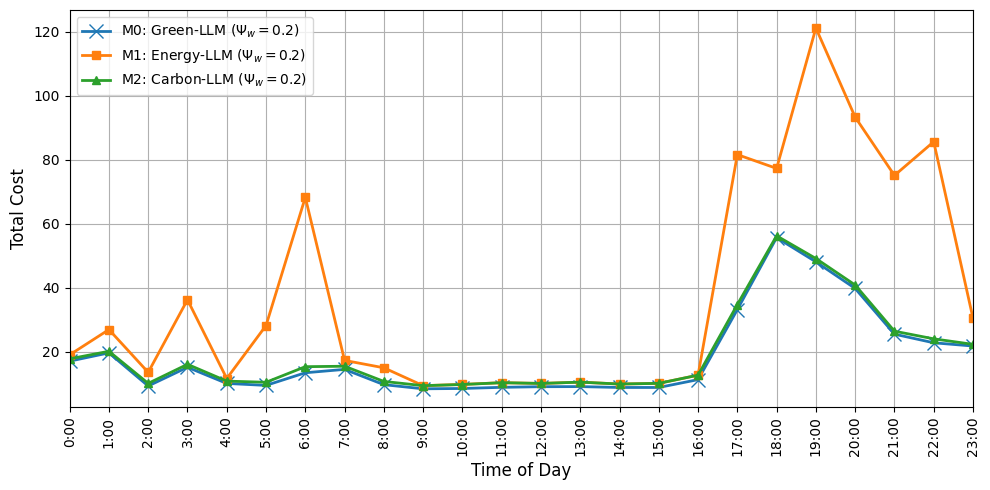

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'model_comparison_results/Theta_cost_with_time_results_20250706_130953.csv'
df = pd.read_csv(file_path)

# Step 2: View column names (optional, for debugging)
print(df.columns.tolist())
# Time labels (hour format)
time_labels = [f"{i}:00" for i in range(24)]

# Step 3: Parse the 'm0_cost_with_time' column
# Use eval safely because the string is a list (e.g., '[1.23, 4.56, ...]')
m0_cost_with_time = df["m0_cost_with_time"].apply(eval)
m1_cost_with_time = df["m1_cost_with_time"].apply(eval)
m2_cost_with_time = df["m2_cost_with_time"].apply(eval)
# print m0_cost with time
print(len(m0_cost_with_time))
# # Step 4: 
plt.figure(figsize=(10, 5))
plt.plot(m0_cost_with_time[5], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
plt.plot(m1_cost_with_time[5], marker='s', linewidth=2,  markersize=6,label='M1: Energy-LLM ($\Psi_w = 0.2$)')
plt.plot(m2_cost_with_time[5], marker='^', linewidth=2,  markersize=6,label='M2: Carbon-LLM ($\Psi_w = 0.2$)')

plt.xticks(ticks=range(0, 24, 1), labels=time_labels[::1], rotation=90)  # Show every 4 hours for clarity
plt.xlabel("Time of Day", fontsize=12)
# Set the x-axis limits to show only the 24-hour period
plt.xlim(0, 23)  # From hour 0 to hour 23
# Ensure ticks are only shown for the 24-hour period
plt.xticks(ticks=range(0, 24), labels=time_labels[:24], rotation=90)

plt.ylabel("Total Cost", fontsize=12)
plt.legend(fontsize=10)  # This shows the legend with your custom labels
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Debug: Check the structure of pareto_solutions
print("Number of solutions:", len(pareto_solutions))
if len(pareto_solutions) > 0:
    print("Keys in first solution:", list(pareto_solutions[0].keys()))
    print("First few solutions structure:")
    for i, sol in enumerate(pareto_solutions[:3]):
        print(f"Solution {i}: {type(sol)}")
        if isinstance(sol, dict):
            print(f"  Keys: {list(sol.keys())}")
            # Check if the expected keys exist
            expected_keys = ['C_energy_cost', 'C_carbon_cost', 'C_delay_cost', 'C_total_cost']
            for key in expected_keys:
                if key in sol:
                    print(f"  {key}: {sol[key]}")
                else:
                    print(f"  {key}: NOT FOUND")
else:
    print("No solutions found!")
    
# Also check pareto_df structure
print("\nPareto DataFrame columns:", list(pareto_df.columns) if pareto_df is not None else "DataFrame is None")
print("DataFrame shape:", pareto_df.shape if pareto_df is not None else "N/A")


Number of solutions: 24
Keys in first solution: ['x', 'P_g', 'P_c', 'P_d', 'D_tran', 'D_prop', 'D_proc', 'woc', 'C_energy_cost', 'C_carbon_cost', 'C_delay_cost', 'C_total_cost', 'objective_value', 'primary_objective', 'epsilon_energy', 'epsilon_carbon', 'epsilon_delay', 'status', 'objective_components']
First few solutions structure:
Solution 0: <class 'dict'>
  Keys: ['x', 'P_g', 'P_c', 'P_d', 'D_tran', 'D_prop', 'D_proc', 'woc', 'C_energy_cost', 'C_carbon_cost', 'C_delay_cost', 'C_total_cost', 'objective_value', 'primary_objective', 'epsilon_energy', 'epsilon_carbon', 'epsilon_delay', 'status', 'objective_components']
  C_energy_cost: 195.87503319677703
  C_carbon_cost: 7.953214507861874
  C_delay_cost: 189.59813803242182
  C_total_cost: 393.42638573706074
Solution 1: <class 'dict'>
  Keys: ['x', 'P_g', 'P_c', 'P_d', 'D_tran', 'D_prop', 'D_proc', 'woc', 'C_energy_cost', 'C_carbon_cost', 'C_delay_cost', 'C_total_cost', 'objective_value', 'primary_objective', 'epsilon_energy', 'epsilon

['Pw_scale', 'm0_carbon_with_time', 'm1_carbon_with_time', 'm2_carbon_with_time', 'm3_carbon_with_time']


<>:50: SyntaxWarning: invalid escape sequence '\P'
<>:51: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:50: SyntaxWarning: invalid escape sequence '\P'
<>:51: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/3743299893.py:50: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m0_carbon_with_time[2], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/3743299893.py:51: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m1_carbon_with_time[2], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/3743299893.py:52: SyntaxWarning: invalid esca

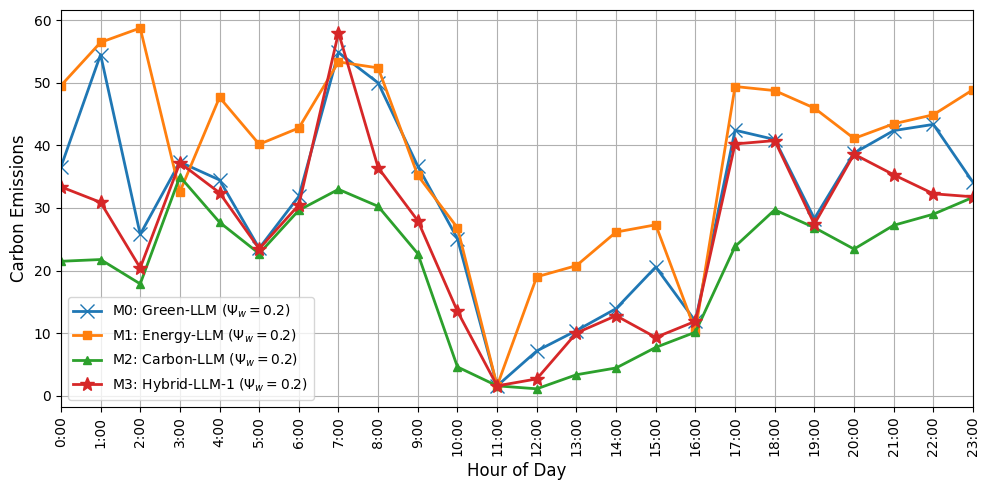

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'model_comparison_results/Pw_carbon_with_time_results_20250701_233816.csv'
df = pd.read_csv(file_path)

# Step 2: View column names (optional, for debugging)
print(df.columns.tolist())
# Time labels (hour format)
time_labels = [f"{i}:00" for i in range(24)]



# Step 3: Parse the 'm0_cost_with_time' column
# Use eval safely because the string is a list (e.g., '[1.23, 4.56, ...]')
m0_carbon_with_time = df["m0_carbon_with_time"].apply(eval)
m1_carbon_with_time = df["m1_carbon_with_time"].apply(eval)
m2_carbon_with_time = df["m2_carbon_with_time"].apply(eval)
m3_carbon_with_time = df["m3_carbon_with_time"].apply(eval)
# Change the type of m0_carbon_with_time to list
# Convert dictionary-like carbon data to lists for plotting
def convert_carbon_dict_to_list(carbon_data):
    """
    Convert carbon data from dictionary format to list format
    Args:
        carbon_data: Series of carbon data (could be list or dict)
    Returns:
        List of carbon data in list format
    """
    result = []
    for entry in carbon_data:
        if isinstance(entry, dict):
            # If it's a dictionary, convert to a list with proper ordering
            ordered_list = [entry.get(t, 0.0) for t in range(24)]
            result.append(ordered_list)
        else:
            # If it's already a list, keep it as is
            result.append(entry)
    return result

# Convert all carbon data to list format
m0_carbon_with_time = convert_carbon_dict_to_list(m0_carbon_with_time)
m1_carbon_with_time = convert_carbon_dict_to_list(m1_carbon_with_time)
m2_carbon_with_time = convert_carbon_dict_to_list(m2_carbon_with_time)
m3_carbon_with_time = convert_carbon_dict_to_list(m3_carbon_with_time)

# # Step 4: 
plt.figure(figsize=(10, 5))
plt.plot(m0_carbon_with_time[2], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
plt.plot(m1_carbon_with_time[2], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 0.2$)')
plt.plot(m2_carbon_with_time[2], marker='^', linewidth=2,  markersize=6, label='M2: Carbon-LLM ($\Psi_w = 0.2$)')
plt.plot(m3_carbon_with_time[2], marker='*', linewidth=2,  markersize=10, label='M3: Hybrid-LLM-1 ($\Psi_w = 0.2$)')

plt.xticks(ticks=range(0, 24, 1), labels=time_labels[::1], rotation=90)  # Show every 4 hours for clarity
plt.xlabel("Hour of Day", fontsize=12)
plt.xlim(0, 23)  # From hour 0 to hour 23


plt.ylabel("Carbon Emissions", fontsize=12)
plt.legend(fontsize=10)  # This shows the legend with your custom labels
plt.grid(True)
plt.tight_layout()
plt.show()


['Pw_scale', 'm0_cost_with_time', 'm1_cost_with_time', 'm2_cost_with_time', 'm3_cost_with_time', 'm0_C_energy_with_time', 'm0_C_carbon_with_time', 'm0_C_delay_with_time', 'm1_C_energy_with_time', 'm1_C_carbon_with_time', 'm1_C_delay_with_time', 'm2_C_energy_with_time', 'm2_C_carbon_with_time', 'm2_C_delay_with_time', 'm3_C_energy_with_time', 'm3_C_carbon_with_time', 'm3_C_delay_with_time']


<>:51: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
<>:51: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/1040210054.py:51: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m0_energy_with_time[2], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/1040210054.py:52: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m1_energy_with_time[2], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/1040210054.py:53: SyntaxWarning: invalid esca

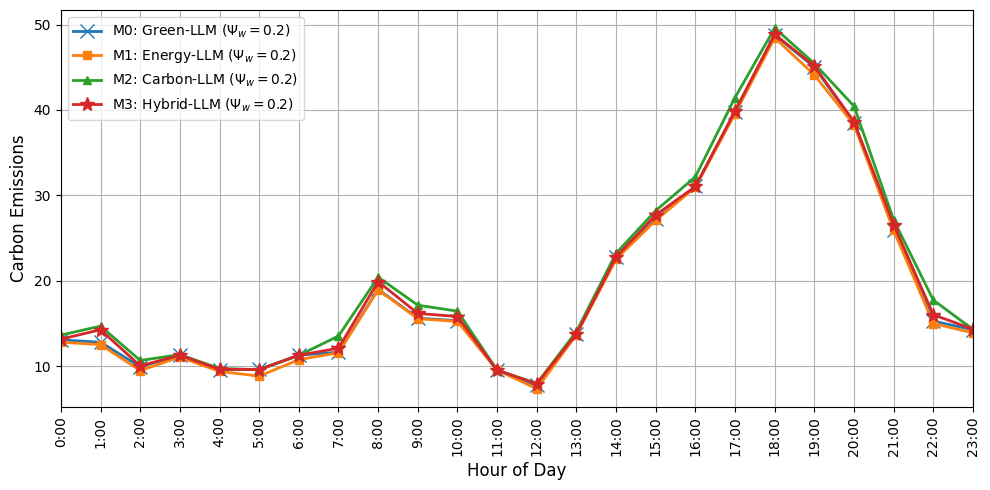

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'model_comparison_results/Pw_cost_with_time_results_20250701_233816.csv'
df = pd.read_csv(file_path)

# Step 2: View column names (optional, for debugging)
print(df.columns.tolist())
# Time labels (hour format)
time_labels = [f"{i}:00" for i in range(24)]

# Step 3: Parse the 'm0_energy_with_time' column
# Use eval safely because the string is a list (e.g., '[1.23, 4.56, ...]')
m0_energy_with_time = df["m0_C_energy_with_time"].apply(eval)
m1_energy_with_time = df["m1_C_energy_with_time"].apply(eval)
m2_energy_with_time = df["m2_C_energy_with_time"].apply(eval)
m3_energy_with_time = df["m3_C_energy_with_time"].apply(eval)
# Change the type of m0_carbon_with_time to list
# Convert dictionary-like carbon data to lists for plotting
def convert_energy_dict_to_list(carbon_data):
    """
    Convert energy data from dictionary format to list format
    Args:
        energy_data: Series of energy data (could be list or dict)
    Returns:
        List of energy data in list format
    """
    result = []
    for entry in carbon_data:
        if isinstance(entry, dict):
            # If it's a dictionary, convert to a list with proper ordering
            ordered_list = [entry.get(t, 0.0) for t in range(24)]
            result.append(ordered_list)
        else:
            # If it's already a list, keep it as is
            result.append(entry)
    return result

# Convert all carbon data to list format
m0_energy_with_time = convert_energy_dict_to_list(m0_energy_with_time)
m1_energy_with_time = convert_energy_dict_to_list(m1_energy_with_time)
m2_energy_with_time = convert_energy_dict_to_list(m2_energy_with_time)
m3_energy_with_time = convert_energy_dict_to_list(m3_energy_with_time)




# # Step 4: 
plt.figure(figsize=(10, 5))
plt.plot(m0_energy_with_time[2], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
plt.plot(m1_energy_with_time[2], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 0.2$)')
plt.plot(m2_energy_with_time[2], marker='^', linewidth=2,  markersize=6, label='M2: Carbon-LLM ($\Psi_w = 0.2$)')
plt.plot(m3_energy_with_time[2], marker='*', linewidth=2,  markersize=10, label='M3: Hybrid-LLM ($\Psi_w = 0.2$)')


plt.xticks(ticks=range(0, 24, 1), labels=time_labels[::1], rotation=90)  # Show every 4 hours for clarity
plt.xlabel("Hour of Day", fontsize=12)
plt.xlim(0, 23)  # From hour 0 to hour 23



plt.ylabel("Carbon Emissions", fontsize=12)
plt.legend(fontsize=10)  # This shows the legend with your custom labels
plt.grid(True)
plt.tight_layout()
plt.show()


['Pw_scale', 'm0_cost_with_time', 'm1_cost_with_time', 'm2_cost_with_time', 'm3_cost_with_time', 'm0_C_energy_with_time', 'm0_C_carbon_with_time', 'm0_C_delay_with_time', 'm1_C_energy_with_time', 'm1_C_carbon_with_time', 'm1_C_delay_with_time', 'm2_C_energy_with_time', 'm2_C_carbon_with_time', 'm2_C_delay_with_time', 'm3_C_energy_with_time', 'm3_C_carbon_with_time', 'm3_C_delay_with_time']


<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
<>:55: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
<>:55: SyntaxWarning: invalid escape sequence '\P'
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/3300995238.py:52: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m0_delay_with_time[2], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/3300995238.py:53: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m1_delay_with_time[2], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 0.2$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_9667/3300995238.py:54: SyntaxWarning: invalid escape

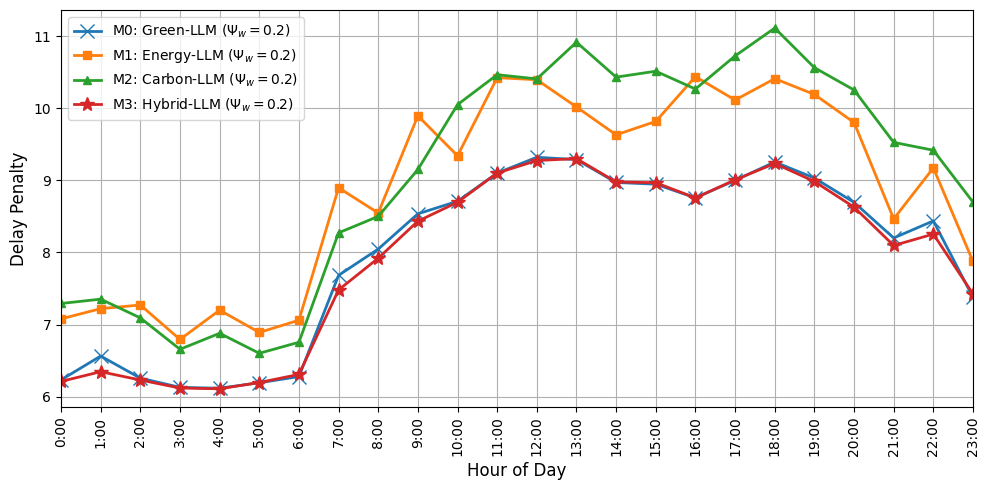

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'model_comparison_results/Pw_cost_with_time_results_20250701_233816.csv'
df = pd.read_csv(file_path)

# Step 2: View column names (optional, for debugging)
print(df.columns.tolist())
# Time labels (hour format)
time_labels = [f"{i}:00" for i in range(24)]


# Use eval safely because the string is a list (e.g., '[1.23, 4.56, ...]')
m0_delay_with_time = df["m0_C_delay_with_time"].apply(eval)
m1_delay_with_time = df["m1_C_delay_with_time"].apply(eval)
m2_delay_with_time = df["m2_C_delay_with_time"].apply(eval)
m3_delay_with_time = df["m3_C_delay_with_time"].apply(eval)
# Change the type of m0_carbon_with_time to list
# Convert dictionary-like carbon data to lists for plotting
def convert_delay_dict_to_list(carbon_data):
    """
    Convert energy data from dictionary format to list format
    Args:
        energy_data: Series of energy data (could be list or dict)
    Returns:
        List of energy data in list format
    """
    result = []
    for entry in carbon_data:
        if isinstance(entry, dict):
            # If it's a dictionary, convert to a list with proper ordering
            ordered_list = [entry.get(t, 0.0) for t in range(24)]
            result.append(ordered_list)
        else:
            # If it's already a list, keep it as is
            result.append(entry)
    return result

# Convert all carbon data to list format
m0_delay_with_time = convert_delay_dict_to_list(m0_delay_with_time)
m1_delay_with_time = convert_delay_dict_to_list(m1_delay_with_time)
m2_delay_with_time = convert_delay_dict_to_list(m2_delay_with_time)
m3_delay_with_time = convert_delay_dict_to_list(m3_delay_with_time)





# # Step 4: 
plt.figure(figsize=(10, 5))
plt.plot(m0_delay_with_time[2], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 0.2$)')
plt.plot(m1_delay_with_time[2], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 0.2$)')
plt.plot(m2_delay_with_time[2], marker='^', linewidth=2,  markersize=6, label='M2: Carbon-LLM ($\Psi_w = 0.2$)')
plt.plot(m3_delay_with_time[2], marker='*', linewidth=2,  markersize=10, label='M3: Hybrid-LLM ($\Psi_w = 0.2$)')      

plt.xticks(ticks=range(0, 24, 1), labels=time_labels[::1], rotation=90)  # Show every 4 hours for clarity
plt.xlabel("Hour of Day", fontsize=12)
plt.xlim(0, 23)  # From hour 0 to hour 23



plt.ylabel("Delay Penalty", fontsize=12)
plt.legend(fontsize=10)  # This shows the legend with your custom labels
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'model_comparison_results/model_water_with_time_results_20250519_224803.csv'
df = pd.read_csv(file_path)

# Step 2: View column names (optional, for debugging)
print(df.columns.tolist())
# Time labels (hour format)
time_labels = [f"{i}:00" for i in range(96)]

# Step 3: Parse the 'm0_cost_with_time' column
# Use eval safely because the string is a list (e.g., '[1.23, 4.56, ...]')
m0_water_with_time = df["m0_woc_with_time"].apply(eval)
m1_water_with_time = df["m1_woc_with_time"].apply(eval)
m2_water_with_time = df["m2_woc_with_time"].apply(eval)
m3_water_with_time = df["m3_woc_with_time"].apply(eval)
m4_water_with_time = df["m4_woc_with_time"].apply(eval)
# Change the type of m0_carbon_with_time to list
# Convert dictionary-like carbon data to lists for plotting
def convert_water_dict_to_list(carbon_data):
    """
    Convert carbon data from dictionary format to list format
    Args:
        carbon_data: Series of carbon data (could be list or dict)
    Returns:
        List of carbon data in list format
    """
    result = []
    for entry in carbon_data:
        if isinstance(entry, dict):
            # If it's a dictionary, convert to a list with proper ordering
            ordered_list = [entry.get(t, 0.0) for t in range(24)]
            result.append(ordered_list)
        else:
            # If it's already a list, keep it as is
            result.append(entry)
    return result

# Convert all water data to list format
m0_water_with_time = convert_water_dict_to_list(m0_water_with_time)
m1_water_with_time = convert_water_dict_to_list(m1_water_with_time)
m2_water_with_time = convert_water_dict_to_list(m2_water_with_time)
m3_water_with_time = convert_water_dict_to_list(m3_water_with_time)
m4_water_with_time = convert_water_dict_to_list(m4_water_with_time)




# # Step 4: 
plt.figure(figsize=(10, 5))
plt.plot(m0_water_with_time[5], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 1.0$)')
plt.plot(m1_water_with_time[5], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 1.0$)')
plt.plot(m2_water_with_time[5], marker='^', linewidth=2,  markersize=6, label='M2: Carbon-LLM ($\Psi_w = 1.0$)')
plt.plot(m3_water_with_time[5], marker='*', linewidth=2,  markersize=10, label='M3: Hybrid-LLM ($\Psi_w = 1.0$)')
plt.plot(m4_water_with_time[5], marker='d', linewidth=2,  markersize=6, label='M4: Hybrid-LLM ($\Psi_w = 1.0$)')

# # plt.xticks(ticks=range(0, 24, 1), labels=time_labels[::1], rotation=45)  # Show every 4 hours for clarity
# plt.xlabel("Time of Day", fontsize=12)

plt.ylabel("Water consumption", fontsize=12)
plt.legend(fontsize=10)  # This shows the legend with your custom labels
plt.grid(True)
plt.tight_layout()
plt.show()


<>:51: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
<>:51: SyntaxWarning: invalid escape sequence '\P'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:54: SyntaxWarning: invalid escape sequence '\P'
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_77037/2547563671.py:51: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m0_water_with_time[5], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 1.0$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_77037/2547563671.py:52: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m1_water_with_time[5], marker='s', linewidth=2,  markersize=6, label='M1: Energy-LLM ($\Psi_w = 1.0$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_77037/2547563671.py:53: SyntaxWarning: invalid esc

FileNotFoundError: [Errno 2] No such file or directory: 'model_comparison_results/model_water_with_time_results_20250519_224803.csv'

['Theta_scale', 'm0_cost_with_time', 'm1_cost_with_time', 'm2_cost_with_time', 'm3_cost_with_time', 'm0_C_energy_with_time', 'm0_C_carbon_with_time', 'm0_C_delay_with_time', 'm1_C_energy_with_time', 'm1_C_carbon_with_time', 'm1_C_delay_with_time', 'm2_C_energy_with_time', 'm2_C_carbon_with_time', 'm2_C_delay_with_time', 'm3_C_energy_with_time', 'm3_C_carbon_with_time', 'm3_C_delay_with_time']
11


<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:25: SyntaxWarning: invalid escape sequence '\P'
<>:26: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:25: SyntaxWarning: invalid escape sequence '\P'
<>:26: SyntaxWarning: invalid escape sequence '\P'
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_48827/2798112665.py:24: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m0_cost_with_time[8], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 1$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_48827/2798112665.py:25: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m1_cost_with_time[8], marker='s', linewidth=2,  markersize=6,label='M1: Energy-LLM ($\Psi_w = 1$)')
/var/folders/55/q8rfcw2n48z882gj6xdq6x380000gn/T/ipykernel_48827/2798112665.py:26: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(m2_cost_with_time[8], marker='*', linewidth=2,  markersize=10,label='M2: Carbon-

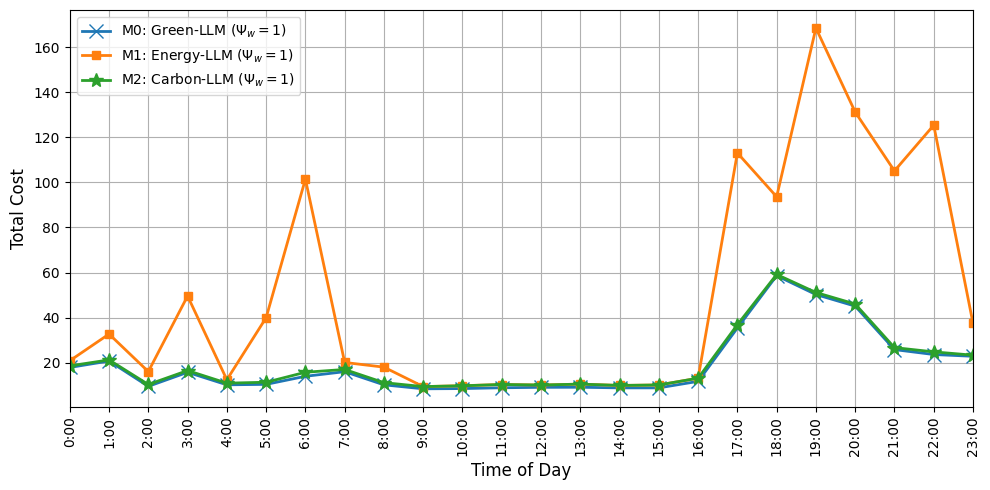

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'model_comparison_results/Theta_cost_with_time_results_20250706_130953.csv'
df = pd.read_csv(file_path)

# Step 2: View column names (optional, for debugging)
print(df.columns.tolist())
# Time labels (hour format)
time_labels = [f"{i}:00" for i in range(24)]

# Step 3: Parse the 'm0_cost_with_time' column
# Use eval safely because the string is a list (e.g., '[1.23, 4.56, ...]')
m0_cost_with_time = df["m0_cost_with_time"].apply(eval)
m1_cost_with_time = df["m1_cost_with_time"].apply(eval)
m2_cost_with_time = df["m2_cost_with_time"].apply(eval)
# m3_cost_with_time = df["m3_cost_with_time"].apply(eval)
# m4_cost_with_time = df["m4_cost_with_time"].apply(eval)
# print m0_cost with time
print(len(m0_cost_with_time))
# # Step 4: 
plt.figure(figsize=(10, 5))
plt.plot(m0_cost_with_time[8], marker='x', linewidth=2,  markersize=10,label='M0: Green-LLM ($\Psi_w = 1$)')
plt.plot(m1_cost_with_time[8], marker='s', linewidth=2,  markersize=6,label='M1: Energy-LLM ($\Psi_w = 1$)')
plt.plot(m2_cost_with_time[8], marker='*', linewidth=2,  markersize=10,label='M2: Carbon-LLM ($\Psi_w = 1$)')
# plt.plot(m3_cost_with_time[8], marker='o', linewidth=2,  markersize=6,label='M3: Hybrid-LLM ($\Psi_w = 1$)')
# plt.plot(m4_cost_with_time[6], marker='d', linewidth=2,  markersize=6,label='M4: Hybrid-LLM ($\Psi_w = 1$)')


plt.xticks(ticks=range(0, 24, 1), labels=time_labels[::1], rotation=90)  # Show every 4 hours for clarity
plt.xlabel("Time of Day", fontsize=12)
# Set the x-axis limits to show only the 24-hour period
plt.xlim(0, 23)  # From hour 0 to hour 23
# Ensure ticks are only shown for the 24-hour period
plt.xticks(ticks=range(0, 24), labels=time_labels[:24], rotation=90)

plt.ylabel("Total Cost", fontsize=12)
plt.legend(fontsize=10)  # This shows the legend with your custom labels
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# Re-import necessary modules after code execution state reset
import pandas as pd
import re

# Load original CSV
df = pd.read_csv("model_comparison_results/Pw_cost_with_time_results_20250701_233816.csv")

# Function to clean and parse list-like strings
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Parse all *_cost_with_time columns
for col in df.columns:
    if "_cost_with_time" in col or "_C_energy_with_time" in col or "_C_carbon_with_time" in col or "_C_delay_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format DataFrame for MATLAB
records = []
for _, row in df.iterrows():
    psi = row["Pw_scale"]
    T = len(row["m0_cost_with_time"])
    for t in range(T):
        records.append({
            "Pw_scale": psi,
            "Time": t,
            "m0_cost": row["m0_cost_with_time"][t],
            "m1_cost": row["m1_cost_with_time"][t],
            "m2_cost": row["m2_cost_with_time"][t],
            "m3_cost": row["m3_cost_with_time"][t],
            "m0_C_energy": row["m0_C_energy_with_time"][t],
            "m1_C_energy": row["m1_C_energy_with_time"][t],
            "m2_C_energy": row["m2_C_energy_with_time"][t],
            "m3_C_energy": row["m3_C_energy_with_time"][t],
            "m0_C_carbon": row["m0_C_carbon_with_time"][t],
            "m1_C_carbon": row["m1_C_carbon_with_time"][t],
            "m2_C_carbon": row["m2_C_carbon_with_time"][t],
            "m3_C_carbon": row["m3_C_carbon_with_time"][t],
            "m0_C_delay": row["m0_C_delay_with_time"][t],
            "m1_C_delay": row["m1_C_delay_with_time"][t],
            "m2_C_delay": row["m2_C_delay_with_time"][t],
            "m3_C_delay": row["m3_C_delay_with_time"][t],
        })

# Save in MATLAB-friendly format
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/Pw_all_in_one_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"Saved to {output_path}")


Saved to model_comparison_results/Pw_all_in_one_flat_for_matlab.csv


In [29]:
# For Matlab plot, we need to flatten the data. This is for the model carbon with time:


import pandas as pd
import re

# Load original carbon CSV
df = pd.read_csv("model_comparison_results/Pw_carbon_with_time_results_20250701_080839.csv")

# Function to safely parse strings containing np.float64 and dicts
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Clean np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try evaluating string
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Apply parser to all *_carbon_with_time columns
for col in df.columns:
    if "_carbon_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format records
records = []
for _, row in df.iterrows():
    psi = row["Pw_scale"]
    T = len(row["m0_carbon_with_time"])
    for t in range(T):
        records.append({
            "Pw_scale": psi,
            "Time": t,
            "m0_carbon": row["m0_carbon_with_time"][t],
            "m1_carbon": row["m1_carbon_with_time"][t],
            "m2_carbon": row["m2_carbon_with_time"][t],
            "m3_carbon": row["m3_carbon_with_time"][t],
        })

# Convert to DataFrame and save
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/Pw_carbon_with_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened carbon CSV saved: {output_path}")

✅ Flattened carbon CSV saved: model_comparison_results/Pw_carbon_with_time_flat_for_matlab.csv


In [58]:
# For Matlab plot, we need to flatten the data. This is for the model carbon with time:


import pandas as pd
import re

# Load original carbon CSV
df = pd.read_csv("model_comparison_results/Pw_cost_with_time_results_20250701_233816.csv")

# Function to safely parse strings containing np.float64 and dicts
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Clean np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try evaluating string
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Apply parser to all *_carbon_with_time columns
for col in df.columns:
    if "_delay_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format records
records = []
for _, row in df.iterrows():
    psi = row["Pw_scale"]
    T = len(row["m0_C_delay_with_time"])
    for t in range(T):
        records.append({
            "Pw_scale": psi,
            "Time": t,
            "m0_delay": row["m0_C_delay_with_time"][t],
            "m1_delay": row["m1_C_delay_with_time"][t],
            "m2_delay": row["m2_C_delay_with_time"][t],
            "m3_delay": row["m3_C_delay_with_time"][t],
        })

# Convert to DataFrame and save
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/Pw_delay_with_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened delay CSV saved: {output_path}")

✅ Flattened delay CSV saved: model_comparison_results/Pw_delay_with_time_flat_for_matlab.csv


In [59]:
# For Matlab plot, we need to flatten the data. This is for the model carbon with time:


import pandas as pd
import re

# Load original carbon CSV
df = pd.read_csv("model_comparison_results/Pw_cost_with_time_results_20250701_233816.csv")

# Function to safely parse strings containing np.float64 and dicts
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Clean np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try evaluating string
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Apply parser to all *_carbon_with_time columns
for col in df.columns:
    if "_cost_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format records
records = []
for _, row in df.iterrows():
    psi = row["Pw_scale"]
    T = len(row["m0_cost_with_time"])
    for t in range(T):
        records.append({
            "Pw_scale": psi,
            "Time": t,
            "m0_cost": row["m0_cost_with_time"][t],
            "m1_cost": row["m1_cost_with_time"][t],
            "m2_cost": row["m2_cost_with_time"][t],
            "m3_cost": row["m3_cost_with_time"][t],
        })

# Convert to DataFrame and save
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/Pw_cost_with_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened delay CSV saved: {output_path}")

✅ Flattened delay CSV saved: model_comparison_results/Pw_cost_with_time_flat_for_matlab.csv


In [7]:
# For Matlab plot, we need to flatten the data. This is for the model cost with time:

import pandas as pd
import re
import json

# Load original CSV
df = pd.read_csv("model_comparison_results/Theta_cost_with_time_results_20250706_130953.csv")

# Function to clean and parse the string
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Replace np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try parsing as dict: {0: 123.4, 1: 234.5, ...}
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Parse all *_cost_with_time columns
for col in df.columns:
    if "_cost_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format DataFrame
records = []
for _, row in df.iterrows():
    psi_theta = row["Theta_scale"]
    T = len(row["m0_cost_with_time"])
    for t in range(T):
        records.append({
            "Theta_scale": psi_theta,
            "Time": t,
            "m0_cost": row["m0_cost_with_time"][t],
            "m1_cost": row["m1_cost_with_time"][t],
            "m2_cost": row["m2_cost_with_time"][t],
            "m3_cost": row["m3_cost_with_time"][t],
        })

df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/Theta_cost_with_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened cost CSV saved: {output_path}")

✅ Flattened cost CSV saved: model_comparison_results/Theta_cost_with_time_flat_for_matlab.csv


In [31]:
# For Matlab plot, we need to flatten the data. This is for the model carbon with time:


import pandas as pd
import re

# Load original carbon CSV
df = pd.read_csv("model_comparison_results/Theta_carbon_with_time_results_20250701_081216.csv")

# Function to safely parse strings containing np.float64 and dicts
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Clean np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try evaluating string
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Apply parser to all *_carbon_with_time columns
for col in df.columns:
    if "_carbon_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format records
records = []
for _, row in df.iterrows():
    psi_theta = row["Theta_scale"]
    T = len(row["m0_carbon_with_time"])
    for t in range(T):
        records.append({
            "Theta_scale": psi_theta,
            "Time": t,
            "m0_carbon": row["m0_carbon_with_time"][t],
            "m1_carbon": row["m1_carbon_with_time"][t],
            "m2_carbon": row["m2_carbon_with_time"][t],
            "m3_carbon": row["m3_carbon_with_time"][t],
        })

# Convert to DataFrame and save
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/Theta_carbon_with_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened carbon CSV saved: {output_path}")

✅ Flattened carbon CSV saved: model_comparison_results/Theta_carbon_with_time_flat_for_matlab.csv


In [44]:


# For Matlab plot, we need to flatten the data. This is for the model carbon with time:


import pandas as pd
import re

# Load original carbon CSV
df = pd.read_csv("model_comparison_results/psi_rho_delay_with_time_results_20250701_093400.csv")

# Function to safely parse strings containing np.float64 and dicts
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Clean np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try evaluating string
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Apply parser to all *_carbon_with_time columns
for col in df.columns:
    if "_delay_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format records
records = []
for _, row in df.iterrows():
    psi_rho = row["psi_rho_scale"]
    T = len(row["m0_C_delay_with_time"])
    for t in range(T):
        records.append({
            "psi_rho_scale": psi_rho,
            "Time": t,
            "m0_delay": row["m0_C_delay_with_time"][t],
            "m1_delay": row["m1_C_delay_with_time"][t],
            "m2_delay": row["m2_C_delay_with_time"][t],
            "m3_delay": row["m3_C_delay_with_time"][t],
        })

# Convert to DataFrame and save
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/psi_rho_delay_with_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened delay CSV saved: {output_path}")

✅ Flattened carbon CSV saved: model_comparison_results/psi_rho_delay_with_time_flat_for_matlab.csv


In [50]:


# For Matlab plot, we need to flatten the data. This is for the model carbon with time:


import pandas as pd
import re

# Load original carbon CSV
df = pd.read_csv("model_comparison_results/psi_rho_cost_with_time_results_20250701_093400.csv")

# Function to safely parse strings containing np.float64 and dicts
def parse_to_list(s):
    if isinstance(s, list):
        return s
    if isinstance(s, float) or isinstance(s, int):
        return [s]
    if not isinstance(s, str):
        return []

    # Clean np.float64(...) → number
    s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)

    # Try evaluating string
    try:
        d = eval(s, {"__builtins__": {}})
        if isinstance(d, dict):
            return [float(d.get(i, 0.0)) for i in range(len(d))]
        elif isinstance(d, list):
            return [float(x) for x in d]
    except:
        return []

# Apply parser to all *_carbon_with_time columns
for col in df.columns:
    if "_cost_with_time" in col:
        df[col] = df[col].apply(parse_to_list)

# Create long-format records
records = []
for _, row in df.iterrows():
    psi_rho = row["psi_rho_scale"]
    T = len(row["m0_cost_with_time"])
    for t in range(T):
        records.append({
            "psi_rho_scale": psi_rho,
            "Time": t,
            "m0_cost": row["m0_cost_with_time"][t],
            "m1_cost": row["m1_cost_with_time"][t],
            "m2_cost": row["m2_cost_with_time"][t],
            "m3_cost": row["m3_cost_with_time"][t],
        })

# Convert to DataFrame and save
df_flat = pd.DataFrame(records)
output_path = "model_comparison_results/psi_rho_cost_time_flat_for_matlab.csv"
df_flat.to_csv(output_path, index=False)
print(f"✅ Flattened cost CSV saved: {output_path}")

✅ Flattened cost CSV saved: model_comparison_results/psi_rho_cost_time_flat_for_matlab.csv
